In [47]:
import numpy as np
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from scipy.stats import pearsonr, spearmanr
import sys, os
sys.path.append('../python_scripts/')
import analysis, datasets, baseline
sys.path.append('../imported_code/svcca/')
import cca_core, pwcca
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

from sklearn.manifold import MDS


# Stolen cordially from http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
'''
Plot Helpers
'''

'''
Visualize RSA
'''
def plot_triple_color(weights, shuffle, both):
    # Establish bounds for shared colorbar
    vmin = min(np.amin(weights), np.amin(shuffle), np.amin(both))
    vmax = max(np.amax(weights), np.amax(shuffle), np.amax(both))
    midpoint = vmin + vmax / 2 # Satisfy function
    norm = MidpointNormalize(midpoint=midpoint,vmin=vmin, vmax=vmax)
    # Create graphs
    cf, (cax1, cax2, cax3) = plt.subplots(1, 3)
    cf.suptitle('Correlation Graphs', fontsize=24)
    cf.set_size_inches((20, 5.5))
    _  = color_plot_helper('Weights', weights, cax1, norm=norm)
    _  = color_plot_helper('Shuffle', shuffle, cax2, norm=norm)
    im = color_plot_helper('Both', both, cax3, norm=norm)
    # Create shared colorbar
    divider = make_axes_locatable(cax3)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=cax)

def plot_triple_diff(weights, shuffle, both):
    # Create variables for readability
    bw = both - weights
    bs = both - shuffle
    ws = weights - shuffle
    # Establish bounds for shared colorbar (midpoint always 0, keep symmetric)
    _min = min(np.amin(bw), np.amin(bs), np.amin(ws))
    _max = max(np.amax(bw), np.amax(bs), np.amax(ws))
    bound = max(abs(_max), abs(_min))
    norm = MidpointNormalize(midpoint=0,vmin=-bound, vmax=bound)
    # Create graphs
    df, (dax1, dax2, dax3) = plt.subplots(1, 3)
    df.suptitle('Difference Graphs', fontsize=24)
    df.set_size_inches((20, 5.5))
    _  = color_plot_helper('Difference: Both - Weights', bw, dax1, norm=norm, color='seismic')
    _  = color_plot_helper('Difference: Both - Shuffle', bs, dax2, norm=norm, color='seismic')
    im = color_plot_helper('Difference: Weights - Shuffle', ws, dax3, norm=norm, color='seismic')
    # Create shared colorbar
    divider = make_axes_locatable(dax3)
    dax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=dax)

def plot_triple_mds(weights, shuffle, both):
    mf, (max1, max2, max3) = plt.subplots(1, 3)
    mf.suptitle('MDS', fontsize=24)
    mf.set_size_inches((20, 5.5))
    mds_plot_helper('Weights', weights, max1)
    mds_plot_helper('Shuffle', shuffle, max2)
    mds_plot_helper('Both', both, max3)


def color_plot_helper(title: str, corr_distance, axis, norm=None, color=None):
    axis.set_title(title, fontsize=16)
    axis.set_xlabel('layer')
    axis.set_xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85])
    axis.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    axis.set_yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85])
    axis.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9])
    axis.set_ylabel('layer')
    cmap = plt.get_cmap(color)
    im = axis.imshow(corr_distance, origin='upper', cmap=cmap, norm=norm)
    return im

def mds_plot_helper(title: str, corr_distance, axis):
    embedding = MDS(n_components=2, dissimilarity='precomputed')
    X_transformed = embedding.fit_transform(corr_distance)
    
    axis.set_title(title, fontsize=16)
    colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
              '#b407ed', '#7d09d6', '#50017a', '#000000']
    for i in range(10):
        axis.set(adjustable='box', aspect='equal')
        axis.plot(X_transformed[i::10, 0], X_transformed[i::10, 1], linestyle='-', color='black', zorder=1)
        axis.scatter(X_transformed[i::10, 0], X_transformed[i::10, 1], marker='o', color=colors, zorder=2)

# 1. Gathering Data and Correlations

In [50]:
'''
Load Data
'''
_, testData = datasets.make_train_data(None)
x_predict, _ = datasets.make_predict_data(testData)

Making train data...
GCN...
ZCA...
Done!
Making test data...
Done!


In [4]:
'''
Calculate RSA
'''
rsa_weights = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict)
rsa_shuffle = 1 - analysis.correlate('RSA', '../outputs/models/shuffle_seed/', x_predict)
rsa_both = 1 - analysis.correlate('RSA', '../outputs/models/both/', x_predict)

**** Load and Preprocess Acts ****
*** Working on w211s311.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w202s302.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getti

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation

Correlation 28 , 13
Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29 , 27
Correlation 29 , 28
Correlation 29 , 29
Correlation 30 , 0
Correlation 30 , 1
Correlation 30 , 2
Correlation 30 , 3
Correlation 30

Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 41 , 17
Correlation 41 , 18
Correlation 41 , 19
Correlation 41 , 20
Correlation 41 , 21
Correlation 41 , 22
Correlation 41 , 23
Correlation 41 , 24
Correlation 41 , 25
Correlation 41 , 26
Correlation 41 , 27
Correlatio

Correlation 49 , 31
Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlation 50 , 18
Correlation 50 , 19
Correlation 50 , 20
Correlation 50 , 21
Correlation 50 , 22
Correlation 50 , 23
Correlation 50 , 24
Correlation 50 , 25
Correlation 50 , 26
Correlation 50 , 27
Correlation 50 , 28
Correlation 50 , 29
Correlation 50 , 30
Correlatio

Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correlation 57 , 54
Correlation 57 , 55
Correlation 57 , 56
Correlation 57 , 57
Correlation 58 , 0
Correlation 58 , 1
Correlation 58 , 2
Correlation 58 , 3
Correlation 58 , 4
Correlation 58 , 5
Correlation 58 , 6
Correlation 58 , 7
Correlation 58 , 8
Correlation 58 , 9
Correlation 58 , 10
Correlation 58 , 11
Correlation 58 , 12
Correlatio

Correlation 64 , 7
Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlation 64 , 41
Correlation 64 , 42
Correlation 64 , 43
Correlation 64 , 44
Correlation 64 , 45
Correlation 64 , 46
Correlation 64 , 47
Correlation 64 , 48
Correlation 64 , 49
Correlation 64 , 50
Correlation 64 , 51
Correlation 64 , 52
Correlation 64 , 53
Correlation 64 , 54
Correlation 64 , 55
Correlation 64 , 56
Cor

Correlation 70 , 16
Correlation 70 , 17
Correlation 70 , 18
Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlation 70 , 50
Correlation 70 , 51
Correlation 70 , 52
Correlation 70 , 53
Correlation 70 , 54
Correlation 70 , 55
Correlation 70 , 56
Correlation 70 , 57
Correlation 70 , 58
Correlation 70 , 59
Correlation 70 , 60
Correlation 70 , 61
Correlation 70 , 62
Correlation 70 , 63
Correlation 70 , 64
Correlation 70 , 65


Correlation 75 , 67
Correlation 75 , 68
Correlation 75 , 69
Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlation 76 , 38
Correlation 76 , 39
Correlation 76 , 40
Correlatio

Correlation 81 , 10
Correlation 81 , 11
Correlation 81 , 12
Correlation 81 , 13
Correlation 81 , 14
Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlation 81 , 40
Correlation 81 , 41
Correlation 81 , 42
Correlation 81 , 43
Correlation 81 , 44
Correlation 81 , 45
Correlation 81 , 46
Correlation 81 , 47
Correlation 81 , 48
Correlation 81 , 49
Correlation 81 , 50
Correlation 81 , 51
Correlation 81 , 52
Correlation 81 , 53
Correlation 81 , 54
Correlation 81 , 55
Correlation 81 , 56
Correlation 81 , 57
Correlation 81 , 58
Correlation 81 , 59


Correlation 86 , 5
Correlation 86 , 6
Correlation 86 , 7
Correlation 86 , 8
Correlation 86 , 9
Correlation 86 , 10
Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlation 86 , 35
Correlation 86 , 36
Correlation 86 , 37
Correlation 86 , 38
Correlation 86 , 39
Correlation 86 , 40
Correlation 86 , 41
Correlation 86 , 42
Correlation 86 , 43
Correlation 86 , 44
Correlation 86 , 45
Correlation 86 , 46
Correlation 86 , 47
Correlation 86 , 48
Correlation 86 , 49
Correlation 86 , 50
Correlation 86 , 51
Correlation 86 , 52
Correlation 86 , 53
Correlation 86 , 54
Corre

In [5]:
'''
Calculate SVCCA
'''
svcca_weights = 1 - analysis.correlate('SVCCA', '../outputs/models/primary/', x_predict)
svcca_shuffle = 1 - analysis.correlate('SVCCA', '../outputs/models/shuffle_seed/', x_predict)
svcca_both = 1 - analysis.correlate('SVCCA', '../outputs/models/both/', x_predict)

**** Load and Preprocess Acts ****
*** Working on w211s311.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found 88 / 96 neurons accounts for 0.9911729 of variance
* Preprocessing...
Found 85 / 96 neurons accounts for 0.9901466 of variance
* Preprocessing...
Found 87 / 96 neurons accounts for 0.99076813 of variance
* Preprocessing...
Found 177 / 192 neurons accounts for 0.9902784 of variance
* Preprocessing...
Found 181 / 192 neurons accounts for 0.99044424 of variance
* Preprocessing...
Found 184 / 192 neurons accounts for 0.99030465 of variance
* Preprocessing...
Found 184 / 192 neurons accounts for 0.9901178 of variance
* Preprocessing...
Found 184 / 192 neurons accounts for 0.9904014 of variance
* Preprocessing...
Found 10 / 10 n

Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found 87 / 96 neurons accounts for 0.9901616 of variance
* Preprocessing...
Found 85 / 96 neurons accounts for 0.9909328 of variance
* Preprocessing...
Found 84 / 96 neurons accounts for 0.9905798 of variance
* Preprocessing...
Found 178 / 192 neurons accounts for 0.99036855 of variance
* Preprocessing...
Found 183 / 192 neurons accounts for 0.9906852 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.9902881 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.99050695 of variance
* Preprocessing...
Found 184 / 192 neurons accounts for 0.99046755 of variance
* Preprocessing...
Found 10 / 10 neurons accounts for 1.0 of variance
*** Working on w205s305.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...

Correlation 25 , 7
Correlation 25 , 8
Correlation 25 , 9
Correlation 25 , 10
Correlation 25 , 11
Correlation 25 , 12
Correlation 25 , 13
Correlation 25 , 14
Correlation 25 , 15
Correlation 25 , 16
Correlation 25 , 17
Correlation 25 , 18
Correlation 25 , 19
Correlation 25 , 20
Correlation 25 , 21
Correlation 25 , 22
Correlation 25 , 23
Correlation 25 , 24
Correlation 25 , 25
Correlation 26 , 0
Correlation 26 , 1
Correlation 26 , 2
Correlation 26 , 3
Correlation 26 , 4
Correlation 26 , 5
Correlation 26 , 6
Correlation 26 , 7
Correlation 26 , 8
Correlation 26 , 9
Correlation 26 , 10
Correlation 26 , 11
Correlation 26 , 12
Correlation 26 , 13
Correlation 26 , 14
Correlation 26 , 15
Correlation 26 , 16
Correlation 26 , 17
Correlation 26 , 18
Correlation 26 , 19
Correlation 26 , 20
Correlation 26 , 21
Correlation 26 , 22
Correlation 26 , 23
Correlation 26 , 24
Correlation 26 , 25
Correlation 26 , 26
Correlation 27 , 0
Correlation 27 , 1
Correlation 27 , 2
Correlation 27 , 3
Correlation 27 , 

Correlation 38 , 10
Correlation 38 , 11
Correlation 38 , 12
Correlation 38 , 13
Correlation 38 , 14
Correlation 38 , 15
Correlation 38 , 16
Correlation 38 , 17
Correlation 38 , 18
Correlation 38 , 19
Correlation 38 , 20
Correlation 38 , 21
Correlation 38 , 22
Correlation 38 , 23
Correlation 38 , 24
Correlation 38 , 25
Correlation 38 , 26
Correlation 38 , 27
Correlation 38 , 28
Correlation 38 , 29
Correlation 38 , 30
Correlation 38 , 31
Correlation 38 , 32
Correlation 38 , 33
Correlation 38 , 34
Correlation 38 , 35
Correlation 38 , 36
Correlation 38 , 37
Correlation 38 , 38
Correlation 39 , 0
Correlation 39 , 1
Correlation 39 , 2
Correlation 39 , 3
Correlation 39 , 4
Correlation 39 , 5
Correlation 39 , 6
Correlation 39 , 7
Correlation 39 , 8
Correlation 39 , 9
Correlation 39 , 10
Correlation 39 , 11
Correlation 39 , 12
Correlation 39 , 13
Correlation 39 , 14
Correlation 39 , 15
Correlation 39 , 16
Correlation 39 , 17
Correlation 39 , 18
Correlation 39 , 19
Correlation 39 , 20
Correlatio

Correlation 47 , 38
Correlation 47 , 39
Correlation 47 , 40
Correlation 47 , 41
Correlation 47 , 42
Correlation 47 , 43
Correlation 47 , 44
Correlation 47 , 45
Correlation 47 , 46
Correlation 47 , 47
Correlation 48 , 0
Correlation 48 , 1
Correlation 48 , 2
Correlation 48 , 3
Correlation 48 , 4
Correlation 48 , 5
Correlation 48 , 6
Correlation 48 , 7
Correlation 48 , 8
Correlation 48 , 9
Correlation 48 , 10
Correlation 48 , 11
Correlation 48 , 12
Correlation 48 , 13
Correlation 48 , 14
Correlation 48 , 15
Correlation 48 , 16
Correlation 48 , 17
Correlation 48 , 18
Correlation 48 , 19
Correlation 48 , 20
Correlation 48 , 21
Correlation 48 , 22
Correlation 48 , 23
Correlation 48 , 24
Correlation 48 , 25
Correlation 48 , 26
Correlation 48 , 27
Correlation 48 , 28
Correlation 48 , 29
Correlation 48 , 30
Correlation 48 , 31
Correlation 48 , 32
Correlation 48 , 33
Correlation 48 , 34
Correlation 48 , 35
Correlation 48 , 36
Correlation 48 , 37
Correlation 48 , 38
Correlation 48 , 39
Correlatio

Correlation 55 , 40
Correlation 55 , 41
Correlation 55 , 42
Correlation 55 , 43
Correlation 55 , 44
Correlation 55 , 45
Correlation 55 , 46
Correlation 55 , 47
Correlation 55 , 48
Correlation 55 , 49
Correlation 55 , 50
Correlation 55 , 51
Correlation 55 , 52
Correlation 55 , 53
Correlation 55 , 54
Correlation 55 , 55
Correlation 56 , 0
Correlation 56 , 1
Correlation 56 , 2
Correlation 56 , 3
Correlation 56 , 4
Correlation 56 , 5
Correlation 56 , 6
Correlation 56 , 7
Correlation 56 , 8
Correlation 56 , 9
Correlation 56 , 10
Correlation 56 , 11
Correlation 56 , 12
Correlation 56 , 13
Correlation 56 , 14
Correlation 56 , 15
Correlation 56 , 16
Correlation 56 , 17
Correlation 56 , 18
Correlation 56 , 19
Correlation 56 , 20
Correlation 56 , 21
Correlation 56 , 22
Correlation 56 , 23
Correlation 56 , 24
Correlation 56 , 25
Correlation 56 , 26
Correlation 56 , 27
Correlation 56 , 28
Correlation 56 , 29
Correlation 56 , 30
Correlation 56 , 31
Correlation 56 , 32
Correlation 56 , 33
Correlatio

Correlation 62 , 41
Correlation 62 , 42
Correlation 62 , 43
Correlation 62 , 44
Correlation 62 , 45
Correlation 62 , 46
Correlation 62 , 47
Correlation 62 , 48
Correlation 62 , 49
Correlation 62 , 50
Correlation 62 , 51
Correlation 62 , 52
Correlation 62 , 53
Correlation 62 , 54
Correlation 62 , 55
Correlation 62 , 56
Correlation 62 , 57
Correlation 62 , 58
Correlation 62 , 59
Correlation 62 , 60
Correlation 62 , 61
Correlation 62 , 62
Correlation 63 , 0
Correlation 63 , 1
Correlation 63 , 2
Correlation 63 , 3
Correlation 63 , 4
Correlation 63 , 5
Correlation 63 , 6
Correlation 63 , 7
Correlation 63 , 8
Correlation 63 , 9
Correlation 63 , 10
Correlation 63 , 11
Correlation 63 , 12
Correlation 63 , 13
Correlation 63 , 14
Correlation 63 , 15
Correlation 63 , 16
Correlation 63 , 17
Correlation 63 , 18
Correlation 63 , 19
Correlation 63 , 20
Correlation 63 , 21
Correlation 63 , 22
Correlation 63 , 23
Correlation 63 , 24
Correlation 63 , 25
Correlation 63 , 26
Correlation 63 , 27
Correlatio

Correlation 68 , 61
Correlation 68 , 62
Correlation 68 , 63
Correlation 68 , 64
Correlation 68 , 65
Correlation 68 , 66
Correlation 68 , 67
Correlation 68 , 68
Correlation 69 , 0
Correlation 69 , 1
Correlation 69 , 2
Correlation 69 , 3
Correlation 69 , 4
Correlation 69 , 5
Correlation 69 , 6
Correlation 69 , 7
Correlation 69 , 8
Correlation 69 , 9
Correlation 69 , 10
Correlation 69 , 11
Correlation 69 , 12
Correlation 69 , 13
Correlation 69 , 14
Correlation 69 , 15
Correlation 69 , 16
Correlation 69 , 17
Correlation 69 , 18
Correlation 69 , 19
Correlation 69 , 20
Correlation 69 , 21
Correlation 69 , 22
Correlation 69 , 23
Correlation 69 , 24
Correlation 69 , 25
Correlation 69 , 26
Correlation 69 , 27
Correlation 69 , 28
Correlation 69 , 29
Correlation 69 , 30
Correlation 69 , 31
Correlation 69 , 32
Correlation 69 , 33
Correlation 69 , 34
Correlation 69 , 35
Correlation 69 , 36
Correlation 69 , 37
Correlation 69 , 38
Correlation 69 , 39
Correlation 69 , 40
Correlation 69 , 41
Correlatio

Correlation 74 , 45
Correlation 74 , 46
Correlation 74 , 47
Correlation 74 , 48
Correlation 74 , 49
Correlation 74 , 50
Correlation 74 , 51
Correlation 74 , 52
Correlation 74 , 53
Correlation 74 , 54
Correlation 74 , 55
Correlation 74 , 56
Correlation 74 , 57
Correlation 74 , 58
Correlation 74 , 59
Correlation 74 , 60
Correlation 74 , 61
Correlation 74 , 62
Correlation 74 , 63
Correlation 74 , 64
Correlation 74 , 65
Correlation 74 , 66
Correlation 74 , 67
Correlation 74 , 68
Correlation 74 , 69
Correlation 74 , 70
Correlation 74 , 71
Correlation 74 , 72
Correlation 74 , 73
Correlation 74 , 74
Correlation 75 , 0
Correlation 75 , 1
Correlation 75 , 2
Correlation 75 , 3
Correlation 75 , 4
Correlation 75 , 5
Correlation 75 , 6
Correlation 75 , 7
Correlation 75 , 8
Correlation 75 , 9
Correlation 75 , 10
Correlation 75 , 11
Correlation 75 , 12
Correlation 75 , 13
Correlation 75 , 14
Correlation 75 , 15
Correlation 75 , 16
Correlation 75 , 17
Correlation 75 , 18
Correlation 75 , 19
Correlatio

Correlation 79 , 73
Correlation 79 , 74
Correlation 79 , 75
Correlation 79 , 76
Correlation 79 , 77
Correlation 79 , 78
Correlation 79 , 79
Correlation 80 , 0
Correlation 80 , 1
Correlation 80 , 2
Correlation 80 , 3
Correlation 80 , 4
Correlation 80 , 5
Correlation 80 , 6
Correlation 80 , 7
Correlation 80 , 8
Correlation 80 , 9
Correlation 80 , 10
Correlation 80 , 11
Correlation 80 , 12
Correlation 80 , 13
Correlation 80 , 14
Correlation 80 , 15
Correlation 80 , 16
Correlation 80 , 17
Correlation 80 , 18
Correlation 80 , 19
Correlation 80 , 20
Correlation 80 , 21
Correlation 80 , 22
Correlation 80 , 23
Correlation 80 , 24
Correlation 80 , 25
Correlation 80 , 26
Correlation 80 , 27
Correlation 80 , 28
Correlation 80 , 29
Correlation 80 , 30
Correlation 80 , 31
Correlation 80 , 32
Correlation 80 , 33
Correlation 80 , 34
Correlation 80 , 35
Correlation 80 , 36
Correlation 80 , 37
Correlation 80 , 38
Correlation 80 , 39
Correlation 80 , 40
Correlation 80 , 41
Correlation 80 , 42
Correlatio

Correlation 84 , 76
Correlation 84 , 77
Correlation 84 , 78
Correlation 84 , 79
Correlation 84 , 80
Correlation 84 , 81
Correlation 84 , 82
Correlation 84 , 83
Correlation 84 , 84
Correlation 85 , 0
Correlation 85 , 1
Correlation 85 , 2
Correlation 85 , 3
Correlation 85 , 4
Correlation 85 , 5
Correlation 85 , 6
Correlation 85 , 7
Correlation 85 , 8
Correlation 85 , 9
Correlation 85 , 10
Correlation 85 , 11
Correlation 85 , 12
Correlation 85 , 13
Correlation 85 , 14
Correlation 85 , 15
Correlation 85 , 16
Correlation 85 , 17
Correlation 85 , 18
Correlation 85 , 19
Correlation 85 , 20
Correlation 85 , 21
Correlation 85 , 22
Correlation 85 , 23
Correlation 85 , 24
Correlation 85 , 25
Correlation 85 , 26
Correlation 85 , 27
Correlation 85 , 28
Correlation 85 , 29
Correlation 85 , 30
Correlation 85 , 31
Correlation 85 , 32
Correlation 85 , 33
Correlation 85 , 34
Correlation 85 , 35
Correlation 85 , 36
Correlation 85 , 37
Correlation 85 , 38
Correlation 85 , 39
Correlation 85 , 40
Correlatio

Correlation 89 , 57
Correlation 89 , 58
Correlation 89 , 59
Correlation 89 , 60
Correlation 89 , 61
Correlation 89 , 62
Correlation 89 , 63
Correlation 89 , 64
Correlation 89 , 65
Correlation 89 , 66
Correlation 89 , 67
Correlation 89 , 68
Correlation 89 , 69
Correlation 89 , 70
Correlation 89 , 71
Correlation 89 , 72
Correlation 89 , 73
Correlation 89 , 74
Correlation 89 , 75
Correlation 89 , 76
Correlation 89 , 77
Correlation 89 , 78
Correlation 89 , 79
Correlation 89 , 80
Correlation 89 , 81
Correlation 89 , 82
Correlation 89 , 83
Correlation 89 , 84
Correlation 89 , 85
Correlation 89 , 86
Correlation 89 , 87
Correlation 89 , 88
Correlation 89 , 89
Done!


In [6]:
'''
Calculate PWCCA
'''
pwcca_weights = 1 - analysis.correlate('PWCCA', '../outputs/models/primary/', x_predict)
pwcca_shuffle = 1 - analysis.correlate('PWCCA', '../outputs/models/shuffle_seed/', x_predict)
pwcca_both = 1 - analysis.correlate('PWCCA', '../outputs/models/both/', x_predict)

**** Load and Preprocess Acts ****
*** Working on w211s311.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
*** Working on w202s302.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
***

Correlation 18 , 5
Correlation 18 , 6
Correlation 18 , 7
Correlation 18 , 8
Correlation 18 , 9
Correlation 18 , 10
Correlation 18 , 11
Correlation 18 , 12
Correlation 18 , 13
Correlation 18 , 14
Correlation 18 , 15
Correlation 18 , 16
Correlation 18 , 17
Correlation 18 , 18
Correlation 19 , 0
Correlation 19 , 1
Correlation 19 , 2
Correlation 19 , 3
Correlation 19 , 4
Correlation 19 , 5
Correlation 19 , 6
Correlation 19 , 7
Correlation 19 , 8
Correlation 19 , 9
Correlation 19 , 10
Correlation 19 , 11
Correlation 19 , 12
Correlation 19 , 13
Correlation 19 , 14
Correlation 19 , 15
Correlation 19 , 16
Correlation 19 , 17
Correlation 19 , 18
Correlation 19 , 19
Correlation 20 , 0
Correlation 20 , 1
Correlation 20 , 2
Correlation 20 , 3
Correlation 20 , 4
Correlation 20 , 5
Correlation 20 , 6
Correlation 20 , 7
Correlation 20 , 8
Correlation 20 , 9
Correlation 20 , 10
Correlation 20 , 11
Correlation 20 , 12
Correlation 20 , 13
Correlation 20 , 14
Correlation 20 , 15
Correlation 20 , 16
Corre

Correlation 33 , 33
Correlation 34 , 0
Correlation 34 , 1
Correlation 34 , 2
Correlation 34 , 3
Correlation 34 , 4
Correlation 34 , 5
Correlation 34 , 6
Correlation 34 , 7
Correlation 34 , 8
Correlation 34 , 9
Correlation 34 , 10
Correlation 34 , 11
Correlation 34 , 12
Correlation 34 , 13
Correlation 34 , 14
Correlation 34 , 15
Correlation 34 , 16
Correlation 34 , 17
Correlation 34 , 18
Correlation 34 , 19
Correlation 34 , 20
Correlation 34 , 21
Correlation 34 , 22
Correlation 34 , 23
Correlation 34 , 24
Correlation 34 , 25
Correlation 34 , 26
Correlation 34 , 27
Correlation 34 , 28
Correlation 34 , 29
Correlation 34 , 30
Correlation 34 , 31
Correlation 34 , 32
Correlation 34 , 33
Correlation 34 , 34
Correlation 35 , 0
Correlation 35 , 1
Correlation 35 , 2
Correlation 35 , 3
Correlation 35 , 4
Correlation 35 , 5
Correlation 35 , 6
Correlation 35 , 7
Correlation 35 , 8
Correlation 35 , 9
Correlation 35 , 10
Correlation 35 , 11
Correlation 35 , 12
Correlation 35 , 13
Correlation 35 , 14


Correlation 44 , 20
Correlation 44 , 21
Correlation 44 , 22
Correlation 44 , 23
Correlation 44 , 24
Correlation 44 , 25
Correlation 44 , 26
Correlation 44 , 27
Correlation 44 , 28
Correlation 44 , 29
Correlation 44 , 30
Correlation 44 , 31
Correlation 44 , 32
Correlation 44 , 33
Correlation 44 , 34
Correlation 44 , 35
Correlation 44 , 36
Correlation 44 , 37
Correlation 44 , 38
Correlation 44 , 39
Correlation 44 , 40
Correlation 44 , 41
Correlation 44 , 42
Correlation 44 , 43
Correlation 44 , 44
Correlation 45 , 0
Correlation 45 , 1
Correlation 45 , 2
Correlation 45 , 3
Correlation 45 , 4
Correlation 45 , 5
Correlation 45 , 6
Correlation 45 , 7
Correlation 45 , 8
Correlation 45 , 9
Correlation 45 , 10
Correlation 45 , 11
Correlation 45 , 12
Correlation 45 , 13
Correlation 45 , 14
Correlation 45 , 15
Correlation 45 , 16
Correlation 45 , 17
Correlation 45 , 18
Correlation 45 , 19
Correlation 45 , 20
Correlation 45 , 21
Correlation 45 , 22
Correlation 45 , 23
Correlation 45 , 24
Correlatio

Correlation 52 , 47
Correlation 52 , 48
Correlation 52 , 49
Correlation 52 , 50
Correlation 52 , 51
Correlation 52 , 52
Correlation 53 , 0
Correlation 53 , 1
Correlation 53 , 2
Correlation 53 , 3
Correlation 53 , 4
Correlation 53 , 5
Correlation 53 , 6
Correlation 53 , 7
Correlation 53 , 8
Correlation 53 , 9
Correlation 53 , 10
Correlation 53 , 11
Correlation 53 , 12
Correlation 53 , 13
Correlation 53 , 14
Correlation 53 , 15
Correlation 53 , 16
Correlation 53 , 17
Correlation 53 , 18
Correlation 53 , 19
Correlation 53 , 20
Correlation 53 , 21
Correlation 53 , 22
Correlation 53 , 23
Correlation 53 , 24
Correlation 53 , 25
Correlation 53 , 26
Correlation 53 , 27
Correlation 53 , 28
Correlation 53 , 29
Correlation 53 , 30
Correlation 53 , 31
Correlation 53 , 32
Correlation 53 , 33
Correlation 53 , 34
Correlation 53 , 35
Correlation 53 , 36
Correlation 53 , 37
Correlation 53 , 38
Correlation 53 , 39
Correlation 53 , 40
Correlation 53 , 41
Correlation 53 , 42
Correlation 53 , 43
Correlatio

Correlation 60 , 10
Correlation 60 , 11
Correlation 60 , 12
Correlation 60 , 13
Correlation 60 , 14
Correlation 60 , 15
Correlation 60 , 16
Correlation 60 , 17
Correlation 60 , 18
Correlation 60 , 19
Correlation 60 , 20
Correlation 60 , 21
Correlation 60 , 22
Correlation 60 , 23
Correlation 60 , 24
Correlation 60 , 25
Correlation 60 , 26
Correlation 60 , 27
Correlation 60 , 28
Correlation 60 , 29
Correlation 60 , 30
Correlation 60 , 31
Correlation 60 , 32
Correlation 60 , 33
Correlation 60 , 34
Correlation 60 , 35
Correlation 60 , 36
Correlation 60 , 37
Correlation 60 , 38
Correlation 60 , 39
Correlation 60 , 40
Correlation 60 , 41
Correlation 60 , 42
Correlation 60 , 43
Correlation 60 , 44
Correlation 60 , 45
Correlation 60 , 46
Correlation 60 , 47
Correlation 60 , 48
Correlation 60 , 49
Correlation 60 , 50
Correlation 60 , 51
Correlation 60 , 52
Correlation 60 , 53
Correlation 60 , 54
Correlation 60 , 55
Correlation 60 , 56
Correlation 60 , 57
Correlation 60 , 58
Correlation 60 , 59


Correlation 66 , 43
Correlation 66 , 44
Correlation 66 , 45
Correlation 66 , 46
Correlation 66 , 47
Correlation 66 , 48
Correlation 66 , 49
Correlation 66 , 50
Correlation 66 , 51
Correlation 66 , 52
Correlation 66 , 53
Correlation 66 , 54
Correlation 66 , 55
Correlation 66 , 56
Correlation 66 , 57
Correlation 66 , 58
Correlation 66 , 59
Correlation 66 , 60
Correlation 66 , 61
Correlation 66 , 62
Correlation 66 , 63
Correlation 66 , 64
Correlation 66 , 65
Correlation 66 , 66
Correlation 67 , 0
Correlation 67 , 1
Correlation 67 , 2
Correlation 67 , 3
Correlation 67 , 4
Correlation 67 , 5
Correlation 67 , 6
Correlation 67 , 7
Correlation 67 , 8
Correlation 67 , 9
Correlation 67 , 10
Correlation 67 , 11
Correlation 67 , 12
Correlation 67 , 13
Correlation 67 , 14
Correlation 67 , 15
Correlation 67 , 16
Correlation 67 , 17
Correlation 67 , 18
Correlation 67 , 19
Correlation 67 , 20
Correlation 67 , 21
Correlation 67 , 22
Correlation 67 , 23
Correlation 67 , 24
Correlation 67 , 25
Correlatio

Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlation 72 , 43
Correlation 72 , 44
Correlation 72 , 45
Correlation 72 , 46
Correlation 72 , 47
Correlation 72 , 48
Correlation 72 , 49
Correlation 72 , 50
Correlation 72 , 51
Correlation 72 , 52
Correlation 72 , 53
Correlation 72 , 54
Correlation 72 , 55
Correlation 72 , 56
Correlation 72 , 57
Correlation 72 , 58
Correlation 72 , 59
Correlation 72 , 60
Correlation 72 , 61
Correlation 72 , 62
Correlation 72 , 63
Correlation 72 , 64
Correlation 72 , 65
Correlation 72 , 66
Correlation 72 , 67
Correlation 72 , 68
Correlation 72 , 69
Correlation 72 , 70
Correlation 72 , 71
Correlation 72 , 72
Correlation 73 , 0
Correlation 73 , 1
Correlation 73 , 2
Correlation 73 , 3
Correlation 73 , 4
Correlation 73 , 5
Correlation 73 , 6
Correlation 73 , 7
Correlation 73 , 8
Correlation 73 , 9
Correlation 73 , 10
Correlation 73 , 11
Correlation 73 , 12
Correlation 73 , 13
Correlation 73 , 14
Correlation 73 , 15
Correlatio

Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correlation 78 , 6
Correlation 78 , 7
Correlation 78 , 8
Correlation 78 , 9
Correlation 78 , 10
Correlation 78 , 11
Correlation 78 , 12
Correlation 78 , 13
Correlation 78 , 14
Correlation 78 , 15
Correlation 78 , 16
Correlation 78 , 17
Correlation 78 , 18
Correlation 78 , 19
Correlation 78 , 20
Correlation 78 , 21
Correlation 78 , 22
Correlation 78 , 23
Correlation 78 , 24
Correlation 78 , 25
Correlation 78 , 26
Correlation 78 , 27
Correlation 78 , 28
Correlation 78 , 29
Correlation 78 , 30
Correlation 78 , 31
Correlation 78 , 32
Correlation 78 , 33
Correlation 78 , 34
Correlation 78 , 35
Correlation 78 , 36
Correlation 78 , 37
Correlation 78 , 38
Correlation 78 , 39
Correlation 78 , 40
Correlation 78 , 41
Correlation 78 , 42
Correlation 78 , 43
Correlation 78 , 44
Correlation 78 , 45
Correlation 78 , 46
Correlation 78 , 47
Correlation 78 , 48
Correlation 78 , 49
Correlatio

Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlation 83 , 15
Correlation 83 , 16
Correlation 83 , 17
Correlation 83 , 18
Correlation 83 , 19
Correlation 83 , 20
Correlation 83 , 21
Correlation 83 , 22
Correlation 83 , 23
Correlation 83 , 24
Correlation 83 , 25
Correlation 83 , 26
Correlation 83 , 27
Correlation 83 , 28
Correlation 83 , 29
Correlation 83 , 30
Correlation 83 , 31
Correlation 83 , 32
Correlation 83 , 33
Correlation 83 , 34
Correlation 83 , 35
Correlation 83 , 36
Correlation 83 , 37
Correlation 83 , 38
Correlation 83 , 39
Correlation 83 , 40
Correlation 83 , 41
Correlation 83 , 42
Correlation 83 , 43
Correlation 83 , 44
Correlation 83 , 45
Correlation 83 , 46
Correlation 83 , 47
Correlation 83 , 48
Correlation 83 , 49
Correlation 83 , 50
Correlation 83 , 51
Correlation 83 , 52
Correlation 83 , 53
Correlation 83 , 54
Correlation 83 , 55
Correlation 83 , 56
Correlation 83 , 57
Correlation 83 , 58
Correlation 83 , 59
Correlation 83 , 60


Correlation 88 , 0
Correlation 88 , 1
Correlation 88 , 2
Correlation 88 , 3
Correlation 88 , 4
Correlation 88 , 5
Correlation 88 , 6
Correlation 88 , 7
Correlation 88 , 8
Correlation 88 , 9
Correlation 88 , 10
Correlation 88 , 11
Correlation 88 , 12
Correlation 88 , 13
Correlation 88 , 14
Correlation 88 , 15
Correlation 88 , 16
Correlation 88 , 17
Correlation 88 , 18
Correlation 88 , 19
Correlation 88 , 20
Correlation 88 , 21
Correlation 88 , 22
Correlation 88 , 23
Correlation 88 , 24
Correlation 88 , 25
Correlation 88 , 26
Correlation 88 , 27
Correlation 88 , 28
Correlation 88 , 29
Correlation 88 , 30
Correlation 88 , 31
Correlation 88 , 32
Correlation 88 , 33
Correlation 88 , 34
Correlation 88 , 35
Correlation 88 , 36
Correlation 88 , 37
Correlation 88 , 38
Correlation 88 , 39
Correlation 88 , 40
Correlation 88 , 41
Correlation 88 , 42
Correlation 88 , 43
Correlation 88 , 44
Correlation 88 , 45
Correlation 88 , 46
Correlation 88 , 47
Correlation 88 , 48
Correlation 88 , 49
Correlatio

In [54]:
'''
Calculate RSA with Cocktail Blank
'''
rsa_weights_cb = 1 - analysis.correlate('RSA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
rsa_shuffle_cb = 1 - analysis.correlate('RSA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
rsa_both_cb = 1 - analysis.correlate('RSA', '../outputs/models/both/', x_predict, cocktail_blank=True)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_207.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer

* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3
Correlation 8 , 4
Correlation 8 , 5
Correlation 8 , 6
Correlation 8 , 7
Correlation 8 , 8
Correlation 9 , 0
Correlation

Correlation 28 , 13
Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29 , 27
Correlation 29 , 28
Correlation 29 , 29
Correlation 30 , 0
Correlation 30 , 1
Correlation 30 , 2
Correlation 30 , 3
Correlation 30

Correlation 40 , 18
Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 41 , 17
Correlation 41 , 18
Correlation 41 , 19
Correlation 41 , 20
Correlation 41 , 21
Correlation 41 , 22
Correlation 41 , 23
Correlation 41 , 24
Correlation 41 , 25
Correlation 41 , 26
Correlatio

Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlation 50 , 18
Correlation 50 , 19
Correlation 50 , 20
Correlation 50 , 21
Correlation 50 , 22
Correlation 50 , 23
Correlation 50 , 24
Correlation 50 , 25
Correlation 50 , 26
Correlation 50 , 27
Correlation 50 , 28
Correlation 50 , 29
Correlation 50 , 30
Correlation 50 , 31
Correlatio

Correlation 57 , 20
Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correlation 57 , 54
Correlation 57 , 55
Correlation 57 , 56
Correlation 57 , 57
Correlation 58 , 0
Correlation 58 , 1
Correlation 58 , 2
Correlation 58 , 3
Correlation 58 , 4
Correlation 58 , 5
Correlation 58 , 6
Correlation 58 , 7
Correlation 58 , 8
Correlation 58 , 9
Correlation 58 , 10
Correlation 58 , 11
Correlatio

Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlation 64 , 41
Correlation 64 , 42
Correlation 64 , 43
Correlation 64 , 44
Correlation 64 , 45
Correlation 64 , 46
Correlation 64 , 47
Correlation 64 , 48
Correlation 64 , 49
Correlation 64 , 50
Correlation 64 , 51
Correlation 64 , 52
Correlation 64 , 53
Correlation 64 , 54
Correlation 64 , 55
Correlation 64 , 56
Correlation 64 , 57
Co

Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlation 70 , 50
Correlation 70 , 51
Correlation 70 , 52
Correlation 70 , 53
Correlation 70 , 54
Correlation 70 , 55
Correlation 70 , 56
Correlation 70 , 57
Correlation 70 , 58
Correlation 70 , 59
Correlation 70 , 60
Correlation 70 , 61
Correlation 70 , 62
Correlation 70 , 63
Correlation 70 , 64
Correlation 70 , 65
Correlation 70 , 66
Correlation 70 , 67
Correlation 70 , 68


Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlation 76 , 22
Correlation 76 , 23
Correlation 76 , 24
Correlation 76 , 25
Correlation 76 , 26
Correlation 76 , 27
Correlation 76 , 28
Correlation 76 , 29
Correlation 76 , 30
Correlation 76 , 31
Correlation 76 , 32
Correlation 76 , 33
Correlation 76 , 34
Correlation 76 , 35
Correlation 76 , 36
Correlation 76 , 37
Correlation 76 , 38
Correlation 76 , 39
Correlation 76 , 40
Correlation 76 , 41
Correlation 76 , 42
Correlation 76 , 43
Correlatio

Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlation 81 , 40
Correlation 81 , 41
Correlation 81 , 42
Correlation 81 , 43
Correlation 81 , 44
Correlation 81 , 45
Correlation 81 , 46
Correlation 81 , 47
Correlation 81 , 48
Correlation 81 , 49
Correlation 81 , 50
Correlation 81 , 51
Correlation 81 , 52
Correlation 81 , 53
Correlation 81 , 54
Correlation 81 , 55
Correlation 81 , 56
Correlation 81 , 57
Correlation 81 , 58
Correlation 81 , 59
Correlation 81 , 60
Correlation 81 , 61
Correlation 81 , 62
Correlation 81 , 63
Correlation 81 , 64


Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlation 86 , 35
Correlation 86 , 36
Correlation 86 , 37
Correlation 86 , 38
Correlation 86 , 39
Correlation 86 , 40
Correlation 86 , 41
Correlation 86 , 42
Correlation 86 , 43
Correlation 86 , 44
Correlation 86 , 45
Correlation 86 , 46
Correlation 86 , 47
Correlation 86 , 48
Correlation 86 , 49
Correlation 86 , 50
Correlation 86 , 51
Correlation 86 , 52
Correlation 86 , 53
Correlation 86 , 54
Correlation 86 , 55
Correlation 86 , 56
Correlation 86 , 57
Correlation 86 , 58
Correlation 86 , 59
Correlation 86 , 60


* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on instance_1012.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images =

Correlation 11 , 1
Correlation 11 , 2
Correlation 11 , 3
Correlation 11 , 4
Correlation 11 , 5
Correlation 11 , 6
Correlation 11 , 7
Correlation 11 , 8
Correlation 11 , 9
Correlation 11 , 10
Correlation 11 , 11
Correlation 12 , 0
Correlation 12 , 1
Correlation 12 , 2
Correlation 12 , 3
Correlation 12 , 4
Correlation 12 , 5
Correlation 12 , 6
Correlation 12 , 7
Correlation 12 , 8
Correlation 12 , 9
Correlation 12 , 10
Correlation 12 , 11
Correlation 12 , 12
Correlation 13 , 0
Correlation 13 , 1
Correlation 13 , 2
Correlation 13 , 3
Correlation 13 , 4
Correlation 13 , 5
Correlation 13 , 6
Correlation 13 , 7
Correlation 13 , 8
Correlation 13 , 9
Correlation 13 , 10
Correlation 13 , 11
Correlation 13 , 12
Correlation 13 , 13
Correlation 14 , 0
Correlation 14 , 1
Correlation 14 , 2
Correlation 14 , 3
Correlation 14 , 4
Correlation 14 , 5
Correlation 14 , 6
Correlation 14 , 7
Correlation 14 , 8
Correlation 14 , 9
Correlation 14 , 10
Correlation 14 , 11
Correlation 14 , 12
Correlation 14 , 13

Correlation 30 , 26
Correlation 30 , 27
Correlation 30 , 28
Correlation 30 , 29
Correlation 30 , 30
Correlation 31 , 0
Correlation 31 , 1
Correlation 31 , 2
Correlation 31 , 3
Correlation 31 , 4
Correlation 31 , 5
Correlation 31 , 6
Correlation 31 , 7
Correlation 31 , 8
Correlation 31 , 9
Correlation 31 , 10
Correlation 31 , 11
Correlation 31 , 12
Correlation 31 , 13
Correlation 31 , 14
Correlation 31 , 15
Correlation 31 , 16
Correlation 31 , 17
Correlation 31 , 18
Correlation 31 , 19
Correlation 31 , 20
Correlation 31 , 21
Correlation 31 , 22
Correlation 31 , 23
Correlation 31 , 24
Correlation 31 , 25
Correlation 31 , 26
Correlation 31 , 27
Correlation 31 , 28
Correlation 31 , 29
Correlation 31 , 30
Correlation 31 , 31
Correlation 32 , 0
Correlation 32 , 1
Correlation 32 , 2
Correlation 32 , 3
Correlation 32 , 4
Correlation 32 , 5
Correlation 32 , 6
Correlation 32 , 7
Correlation 32 , 8
Correlation 32 , 9
Correlation 32 , 10
Correlation 32 , 11
Correlation 32 , 12
Correlation 32 , 13


Correlation 42 , 8
Correlation 42 , 9
Correlation 42 , 10
Correlation 42 , 11
Correlation 42 , 12
Correlation 42 , 13
Correlation 42 , 14
Correlation 42 , 15
Correlation 42 , 16
Correlation 42 , 17
Correlation 42 , 18
Correlation 42 , 19
Correlation 42 , 20
Correlation 42 , 21
Correlation 42 , 22
Correlation 42 , 23
Correlation 42 , 24
Correlation 42 , 25
Correlation 42 , 26
Correlation 42 , 27
Correlation 42 , 28
Correlation 42 , 29
Correlation 42 , 30
Correlation 42 , 31
Correlation 42 , 32
Correlation 42 , 33
Correlation 42 , 34
Correlation 42 , 35
Correlation 42 , 36
Correlation 42 , 37
Correlation 42 , 38
Correlation 42 , 39
Correlation 42 , 40
Correlation 42 , 41
Correlation 42 , 42
Correlation 43 , 0
Correlation 43 , 1
Correlation 43 , 2
Correlation 43 , 3
Correlation 43 , 4
Correlation 43 , 5
Correlation 43 , 6
Correlation 43 , 7
Correlation 43 , 8
Correlation 43 , 9
Correlation 43 , 10
Correlation 43 , 11
Correlation 43 , 12
Correlation 43 , 13
Correlation 43 , 14
Correlation 

Correlation 51 , 0
Correlation 51 , 1
Correlation 51 , 2
Correlation 51 , 3
Correlation 51 , 4
Correlation 51 , 5
Correlation 51 , 6
Correlation 51 , 7
Correlation 51 , 8
Correlation 51 , 9
Correlation 51 , 10
Correlation 51 , 11
Correlation 51 , 12
Correlation 51 , 13
Correlation 51 , 14
Correlation 51 , 15
Correlation 51 , 16
Correlation 51 , 17
Correlation 51 , 18
Correlation 51 , 19
Correlation 51 , 20
Correlation 51 , 21
Correlation 51 , 22
Correlation 51 , 23
Correlation 51 , 24
Correlation 51 , 25
Correlation 51 , 26
Correlation 51 , 27
Correlation 51 , 28
Correlation 51 , 29
Correlation 51 , 30
Correlation 51 , 31
Correlation 51 , 32
Correlation 51 , 33
Correlation 51 , 34
Correlation 51 , 35
Correlation 51 , 36
Correlation 51 , 37
Correlation 51 , 38
Correlation 51 , 39
Correlation 51 , 40
Correlation 51 , 41
Correlation 51 , 42
Correlation 51 , 43
Correlation 51 , 44
Correlation 51 , 45
Correlation 51 , 46
Correlation 51 , 47
Correlation 51 , 48
Correlation 51 , 49
Correlatio

Correlation 58 , 29
Correlation 58 , 30
Correlation 58 , 31
Correlation 58 , 32
Correlation 58 , 33
Correlation 58 , 34
Correlation 58 , 35
Correlation 58 , 36
Correlation 58 , 37
Correlation 58 , 38
Correlation 58 , 39
Correlation 58 , 40
Correlation 58 , 41
Correlation 58 , 42
Correlation 58 , 43
Correlation 58 , 44
Correlation 58 , 45
Correlation 58 , 46
Correlation 58 , 47
Correlation 58 , 48
Correlation 58 , 49
Correlation 58 , 50
Correlation 58 , 51
Correlation 58 , 52
Correlation 58 , 53
Correlation 58 , 54
Correlation 58 , 55
Correlation 58 , 56
Correlation 58 , 57
Correlation 58 , 58
Correlation 59 , 0
Correlation 59 , 1
Correlation 59 , 2
Correlation 59 , 3
Correlation 59 , 4
Correlation 59 , 5
Correlation 59 , 6
Correlation 59 , 7
Correlation 59 , 8
Correlation 59 , 9
Correlation 59 , 10
Correlation 59 , 11
Correlation 59 , 12
Correlation 59 , 13
Correlation 59 , 14
Correlation 59 , 15
Correlation 59 , 16
Correlation 59 , 17
Correlation 59 , 18
Correlation 59 , 19
Correlatio

Correlation 65 , 10
Correlation 65 , 11
Correlation 65 , 12
Correlation 65 , 13
Correlation 65 , 14
Correlation 65 , 15
Correlation 65 , 16
Correlation 65 , 17
Correlation 65 , 18
Correlation 65 , 19
Correlation 65 , 20
Correlation 65 , 21
Correlation 65 , 22
Correlation 65 , 23
Correlation 65 , 24
Correlation 65 , 25
Correlation 65 , 26
Correlation 65 , 27
Correlation 65 , 28
Correlation 65 , 29
Correlation 65 , 30
Correlation 65 , 31
Correlation 65 , 32
Correlation 65 , 33
Correlation 65 , 34
Correlation 65 , 35
Correlation 65 , 36
Correlation 65 , 37
Correlation 65 , 38
Correlation 65 , 39
Correlation 65 , 40
Correlation 65 , 41
Correlation 65 , 42
Correlation 65 , 43
Correlation 65 , 44
Correlation 65 , 45
Correlation 65 , 46
Correlation 65 , 47
Correlation 65 , 48
Correlation 65 , 49
Correlation 65 , 50
Correlation 65 , 51
Correlation 65 , 52
Correlation 65 , 53
Correlation 65 , 54
Correlation 65 , 55
Correlation 65 , 56
Correlation 65 , 57
Correlation 65 , 58
Correlation 65 , 59


Correlation 71 , 15
Correlation 71 , 16
Correlation 71 , 17
Correlation 71 , 18
Correlation 71 , 19
Correlation 71 , 20
Correlation 71 , 21
Correlation 71 , 22
Correlation 71 , 23
Correlation 71 , 24
Correlation 71 , 25
Correlation 71 , 26
Correlation 71 , 27
Correlation 71 , 28
Correlation 71 , 29
Correlation 71 , 30
Correlation 71 , 31
Correlation 71 , 32
Correlation 71 , 33
Correlation 71 , 34
Correlation 71 , 35
Correlation 71 , 36
Correlation 71 , 37
Correlation 71 , 38
Correlation 71 , 39
Correlation 71 , 40
Correlation 71 , 41
Correlation 71 , 42
Correlation 71 , 43
Correlation 71 , 44
Correlation 71 , 45
Correlation 71 , 46
Correlation 71 , 47
Correlation 71 , 48
Correlation 71 , 49
Correlation 71 , 50
Correlation 71 , 51
Correlation 71 , 52
Correlation 71 , 53
Correlation 71 , 54
Correlation 71 , 55
Correlation 71 , 56
Correlation 71 , 57
Correlation 71 , 58
Correlation 71 , 59
Correlation 71 , 60
Correlation 71 , 61
Correlation 71 , 62
Correlation 71 , 63
Correlation 71 , 64


Correlation 76 , 59
Correlation 76 , 60
Correlation 76 , 61
Correlation 76 , 62
Correlation 76 , 63
Correlation 76 , 64
Correlation 76 , 65
Correlation 76 , 66
Correlation 76 , 67
Correlation 76 , 68
Correlation 76 , 69
Correlation 76 , 70
Correlation 76 , 71
Correlation 76 , 72
Correlation 76 , 73
Correlation 76 , 74
Correlation 76 , 75
Correlation 76 , 76
Correlation 77 , 0
Correlation 77 , 1
Correlation 77 , 2
Correlation 77 , 3
Correlation 77 , 4
Correlation 77 , 5
Correlation 77 , 6
Correlation 77 , 7
Correlation 77 , 8
Correlation 77 , 9
Correlation 77 , 10
Correlation 77 , 11
Correlation 77 , 12
Correlation 77 , 13
Correlation 77 , 14
Correlation 77 , 15
Correlation 77 , 16
Correlation 77 , 17
Correlation 77 , 18
Correlation 77 , 19
Correlation 77 , 20
Correlation 77 , 21
Correlation 77 , 22
Correlation 77 , 23
Correlation 77 , 24
Correlation 77 , 25
Correlation 77 , 26
Correlation 77 , 27
Correlation 77 , 28
Correlation 77 , 29
Correlation 77 , 30
Correlation 77 , 31
Correlatio

Correlation 81 , 78
Correlation 81 , 79
Correlation 81 , 80
Correlation 81 , 81
Correlation 82 , 0
Correlation 82 , 1
Correlation 82 , 2
Correlation 82 , 3
Correlation 82 , 4
Correlation 82 , 5
Correlation 82 , 6
Correlation 82 , 7
Correlation 82 , 8
Correlation 82 , 9
Correlation 82 , 10
Correlation 82 , 11
Correlation 82 , 12
Correlation 82 , 13
Correlation 82 , 14
Correlation 82 , 15
Correlation 82 , 16
Correlation 82 , 17
Correlation 82 , 18
Correlation 82 , 19
Correlation 82 , 20
Correlation 82 , 21
Correlation 82 , 22
Correlation 82 , 23
Correlation 82 , 24
Correlation 82 , 25
Correlation 82 , 26
Correlation 82 , 27
Correlation 82 , 28
Correlation 82 , 29
Correlation 82 , 30
Correlation 82 , 31
Correlation 82 , 32
Correlation 82 , 33
Correlation 82 , 34
Correlation 82 , 35
Correlation 82 , 36
Correlation 82 , 37
Correlation 82 , 38
Correlation 82 , 39
Correlation 82 , 40
Correlation 82 , 41
Correlation 82 , 42
Correlation 82 , 43
Correlation 82 , 44
Correlation 82 , 45
Correlatio

Correlation 86 , 73
Correlation 86 , 74
Correlation 86 , 75
Correlation 86 , 76
Correlation 86 , 77
Correlation 86 , 78
Correlation 86 , 79
Correlation 86 , 80
Correlation 86 , 81
Correlation 86 , 82
Correlation 86 , 83
Correlation 86 , 84
Correlation 86 , 85
Correlation 86 , 86
Correlation 87 , 0
Correlation 87 , 1
Correlation 87 , 2
Correlation 87 , 3
Correlation 87 , 4
Correlation 87 , 5
Correlation 87 , 6
Correlation 87 , 7
Correlation 87 , 8
Correlation 87 , 9
Correlation 87 , 10
Correlation 87 , 11
Correlation 87 , 12
Correlation 87 , 13
Correlation 87 , 14
Correlation 87 , 15
Correlation 87 , 16
Correlation 87 , 17
Correlation 87 , 18
Correlation 87 , 19
Correlation 87 , 20
Correlation 87 , 21
Correlation 87 , 22
Correlation 87 , 23
Correlation 87 , 24
Correlation 87 , 25
Correlation 87 , 26
Correlation 87 , 27
Correlation 87 , 28
Correlation 87 , 29
Correlation 87 , 30
Correlation 87 , 31
Correlation 87 , 32
Correlation 87 , 33
Correlation 87 , 34
Correlation 87 , 35
Correlatio

Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 98304)
num_images = 1000
* Preprocessing...
shape: (1000, 24576)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 49152)
num_images = 1000
* Preprocessing...
shape: (1000, 12288)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 6912)
num_images = 1000
* Preprocessing...
shape: (1000, 360)
num_images = 1000
*** Working on w1200s1300.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting

Correlation 15 , 12
Correlation 15 , 13
Correlation 15 , 14
Correlation 15 , 15
Correlation 16 , 0
Correlation 16 , 1
Correlation 16 , 2
Correlation 16 , 3
Correlation 16 , 4
Correlation 16 , 5
Correlation 16 , 6
Correlation 16 , 7
Correlation 16 , 8
Correlation 16 , 9
Correlation 16 , 10
Correlation 16 , 11
Correlation 16 , 12
Correlation 16 , 13
Correlation 16 , 14
Correlation 16 , 15
Correlation 16 , 16
Correlation 17 , 0
Correlation 17 , 1
Correlation 17 , 2
Correlation 17 , 3
Correlation 17 , 4
Correlation 17 , 5
Correlation 17 , 6
Correlation 17 , 7
Correlation 17 , 8
Correlation 17 , 9
Correlation 17 , 10
Correlation 17 , 11
Correlation 17 , 12
Correlation 17 , 13
Correlation 17 , 14
Correlation 17 , 15
Correlation 17 , 16
Correlation 17 , 17
Correlation 18 , 0
Correlation 18 , 1
Correlation 18 , 2
Correlation 18 , 3
Correlation 18 , 4
Correlation 18 , 5
Correlation 18 , 6
Correlation 18 , 7
Correlation 18 , 8
Correlation 18 , 9
Correlation 18 , 10
Correlation 18 , 11
Correlatio

Correlation 32 , 27
Correlation 32 , 28
Correlation 32 , 29
Correlation 32 , 30
Correlation 32 , 31
Correlation 32 , 32
Correlation 33 , 0
Correlation 33 , 1
Correlation 33 , 2
Correlation 33 , 3
Correlation 33 , 4
Correlation 33 , 5
Correlation 33 , 6
Correlation 33 , 7
Correlation 33 , 8
Correlation 33 , 9
Correlation 33 , 10
Correlation 33 , 11
Correlation 33 , 12
Correlation 33 , 13
Correlation 33 , 14
Correlation 33 , 15
Correlation 33 , 16
Correlation 33 , 17
Correlation 33 , 18
Correlation 33 , 19
Correlation 33 , 20
Correlation 33 , 21
Correlation 33 , 22
Correlation 33 , 23
Correlation 33 , 24
Correlation 33 , 25
Correlation 33 , 26
Correlation 33 , 27
Correlation 33 , 28
Correlation 33 , 29
Correlation 33 , 30
Correlation 33 , 31
Correlation 33 , 32
Correlation 33 , 33
Correlation 34 , 0
Correlation 34 , 1
Correlation 34 , 2
Correlation 34 , 3
Correlation 34 , 4
Correlation 34 , 5
Correlation 34 , 6
Correlation 34 , 7
Correlation 34 , 8
Correlation 34 , 9
Correlation 34 , 10


Correlation 43 , 26
Correlation 43 , 27
Correlation 43 , 28
Correlation 43 , 29
Correlation 43 , 30
Correlation 43 , 31
Correlation 43 , 32
Correlation 43 , 33
Correlation 43 , 34
Correlation 43 , 35
Correlation 43 , 36
Correlation 43 , 37
Correlation 43 , 38
Correlation 43 , 39
Correlation 43 , 40
Correlation 43 , 41
Correlation 43 , 42
Correlation 43 , 43
Correlation 44 , 0
Correlation 44 , 1
Correlation 44 , 2
Correlation 44 , 3
Correlation 44 , 4
Correlation 44 , 5
Correlation 44 , 6
Correlation 44 , 7
Correlation 44 , 8
Correlation 44 , 9
Correlation 44 , 10
Correlation 44 , 11
Correlation 44 , 12
Correlation 44 , 13
Correlation 44 , 14
Correlation 44 , 15
Correlation 44 , 16
Correlation 44 , 17
Correlation 44 , 18
Correlation 44 , 19
Correlation 44 , 20
Correlation 44 , 21
Correlation 44 , 22
Correlation 44 , 23
Correlation 44 , 24
Correlation 44 , 25
Correlation 44 , 26
Correlation 44 , 27
Correlation 44 , 28
Correlation 44 , 29
Correlation 44 , 30
Correlation 44 , 31
Correlatio

Correlation 52 , 12
Correlation 52 , 13
Correlation 52 , 14
Correlation 52 , 15
Correlation 52 , 16
Correlation 52 , 17
Correlation 52 , 18
Correlation 52 , 19
Correlation 52 , 20
Correlation 52 , 21
Correlation 52 , 22
Correlation 52 , 23
Correlation 52 , 24
Correlation 52 , 25
Correlation 52 , 26
Correlation 52 , 27
Correlation 52 , 28
Correlation 52 , 29
Correlation 52 , 30
Correlation 52 , 31
Correlation 52 , 32
Correlation 52 , 33
Correlation 52 , 34
Correlation 52 , 35
Correlation 52 , 36
Correlation 52 , 37
Correlation 52 , 38
Correlation 52 , 39
Correlation 52 , 40
Correlation 52 , 41
Correlation 52 , 42
Correlation 52 , 43
Correlation 52 , 44
Correlation 52 , 45
Correlation 52 , 46
Correlation 52 , 47
Correlation 52 , 48
Correlation 52 , 49
Correlation 52 , 50
Correlation 52 , 51
Correlation 52 , 52
Correlation 53 , 0
Correlation 53 , 1
Correlation 53 , 2
Correlation 53 , 3
Correlation 53 , 4
Correlation 53 , 5
Correlation 53 , 6
Correlation 53 , 7
Correlation 53 , 8
Correlati

Correlation 59 , 38
Correlation 59 , 39
Correlation 59 , 40
Correlation 59 , 41
Correlation 59 , 42
Correlation 59 , 43
Correlation 59 , 44
Correlation 59 , 45
Correlation 59 , 46
Correlation 59 , 47
Correlation 59 , 48
Correlation 59 , 49
Correlation 59 , 50
Correlation 59 , 51
Correlation 59 , 52
Correlation 59 , 53
Correlation 59 , 54
Correlation 59 , 55
Correlation 59 , 56
Correlation 59 , 57
Correlation 59 , 58
Correlation 59 , 59
Correlation 60 , 0
Correlation 60 , 1
Correlation 60 , 2
Correlation 60 , 3
Correlation 60 , 4
Correlation 60 , 5
Correlation 60 , 6
Correlation 60 , 7
Correlation 60 , 8
Correlation 60 , 9
Correlation 60 , 10
Correlation 60 , 11
Correlation 60 , 12
Correlation 60 , 13
Correlation 60 , 14
Correlation 60 , 15
Correlation 60 , 16
Correlation 60 , 17
Correlation 60 , 18
Correlation 60 , 19
Correlation 60 , 20
Correlation 60 , 21
Correlation 60 , 22
Correlation 60 , 23
Correlation 60 , 24
Correlation 60 , 25
Correlation 60 , 26
Correlation 60 , 27
Correlatio

Correlation 66 , 15
Correlation 66 , 16
Correlation 66 , 17
Correlation 66 , 18
Correlation 66 , 19
Correlation 66 , 20
Correlation 66 , 21
Correlation 66 , 22
Correlation 66 , 23
Correlation 66 , 24
Correlation 66 , 25
Correlation 66 , 26
Correlation 66 , 27
Correlation 66 , 28
Correlation 66 , 29
Correlation 66 , 30
Correlation 66 , 31
Correlation 66 , 32
Correlation 66 , 33
Correlation 66 , 34
Correlation 66 , 35
Correlation 66 , 36
Correlation 66 , 37
Correlation 66 , 38
Correlation 66 , 39
Correlation 66 , 40
Correlation 66 , 41
Correlation 66 , 42
Correlation 66 , 43
Correlation 66 , 44
Correlation 66 , 45
Correlation 66 , 46
Correlation 66 , 47
Correlation 66 , 48
Correlation 66 , 49
Correlation 66 , 50
Correlation 66 , 51
Correlation 66 , 52
Correlation 66 , 53
Correlation 66 , 54
Correlation 66 , 55
Correlation 66 , 56
Correlation 66 , 57
Correlation 66 , 58
Correlation 66 , 59
Correlation 66 , 60
Correlation 66 , 61
Correlation 66 , 62
Correlation 66 , 63
Correlation 66 , 64


Correlation 72 , 14
Correlation 72 , 15
Correlation 72 , 16
Correlation 72 , 17
Correlation 72 , 18
Correlation 72 , 19
Correlation 72 , 20
Correlation 72 , 21
Correlation 72 , 22
Correlation 72 , 23
Correlation 72 , 24
Correlation 72 , 25
Correlation 72 , 26
Correlation 72 , 27
Correlation 72 , 28
Correlation 72 , 29
Correlation 72 , 30
Correlation 72 , 31
Correlation 72 , 32
Correlation 72 , 33
Correlation 72 , 34
Correlation 72 , 35
Correlation 72 , 36
Correlation 72 , 37
Correlation 72 , 38
Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlation 72 , 43
Correlation 72 , 44
Correlation 72 , 45
Correlation 72 , 46
Correlation 72 , 47
Correlation 72 , 48
Correlation 72 , 49
Correlation 72 , 50
Correlation 72 , 51
Correlation 72 , 52
Correlation 72 , 53
Correlation 72 , 54
Correlation 72 , 55
Correlation 72 , 56
Correlation 72 , 57
Correlation 72 , 58
Correlation 72 , 59
Correlation 72 , 60
Correlation 72 , 61
Correlation 72 , 62
Correlation 72 , 63


Correlation 77 , 56
Correlation 77 , 57
Correlation 77 , 58
Correlation 77 , 59
Correlation 77 , 60
Correlation 77 , 61
Correlation 77 , 62
Correlation 77 , 63
Correlation 77 , 64
Correlation 77 , 65
Correlation 77 , 66
Correlation 77 , 67
Correlation 77 , 68
Correlation 77 , 69
Correlation 77 , 70
Correlation 77 , 71
Correlation 77 , 72
Correlation 77 , 73
Correlation 77 , 74
Correlation 77 , 75
Correlation 77 , 76
Correlation 77 , 77
Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correlation 78 , 6
Correlation 78 , 7
Correlation 78 , 8
Correlation 78 , 9
Correlation 78 , 10
Correlation 78 , 11
Correlation 78 , 12
Correlation 78 , 13
Correlation 78 , 14
Correlation 78 , 15
Correlation 78 , 16
Correlation 78 , 17
Correlation 78 , 18
Correlation 78 , 19
Correlation 78 , 20
Correlation 78 , 21
Correlation 78 , 22
Correlation 78 , 23
Correlation 78 , 24
Correlation 78 , 25
Correlation 78 , 26
Correlation 78 , 27
Correlatio

Correlation 82 , 70
Correlation 82 , 71
Correlation 82 , 72
Correlation 82 , 73
Correlation 82 , 74
Correlation 82 , 75
Correlation 82 , 76
Correlation 82 , 77
Correlation 82 , 78
Correlation 82 , 79
Correlation 82 , 80
Correlation 82 , 81
Correlation 82 , 82
Correlation 83 , 0
Correlation 83 , 1
Correlation 83 , 2
Correlation 83 , 3
Correlation 83 , 4
Correlation 83 , 5
Correlation 83 , 6
Correlation 83 , 7
Correlation 83 , 8
Correlation 83 , 9
Correlation 83 , 10
Correlation 83 , 11
Correlation 83 , 12
Correlation 83 , 13
Correlation 83 , 14
Correlation 83 , 15
Correlation 83 , 16
Correlation 83 , 17
Correlation 83 , 18
Correlation 83 , 19
Correlation 83 , 20
Correlation 83 , 21
Correlation 83 , 22
Correlation 83 , 23
Correlation 83 , 24
Correlation 83 , 25
Correlation 83 , 26
Correlation 83 , 27
Correlation 83 , 28
Correlation 83 , 29
Correlation 83 , 30
Correlation 83 , 31
Correlation 83 , 32
Correlation 83 , 33
Correlation 83 , 34
Correlation 83 , 35
Correlation 83 , 36
Correlatio

Correlation 87 , 60
Correlation 87 , 61
Correlation 87 , 62
Correlation 87 , 63
Correlation 87 , 64
Correlation 87 , 65
Correlation 87 , 66
Correlation 87 , 67
Correlation 87 , 68
Correlation 87 , 69
Correlation 87 , 70
Correlation 87 , 71
Correlation 87 , 72
Correlation 87 , 73
Correlation 87 , 74
Correlation 87 , 75
Correlation 87 , 76
Correlation 87 , 77
Correlation 87 , 78
Correlation 87 , 79
Correlation 87 , 80
Correlation 87 , 81
Correlation 87 , 82
Correlation 87 , 83
Correlation 87 , 84
Correlation 87 , 85
Correlation 87 , 86
Correlation 87 , 87
Correlation 88 , 0
Correlation 88 , 1
Correlation 88 , 2
Correlation 88 , 3
Correlation 88 , 4
Correlation 88 , 5
Correlation 88 , 6
Correlation 88 , 7
Correlation 88 , 8
Correlation 88 , 9
Correlation 88 , 10
Correlation 88 , 11
Correlation 88 , 12
Correlation 88 , 13
Correlation 88 , 14
Correlation 88 , 15
Correlation 88 , 16
Correlation 88 , 17
Correlation 88 , 18
Correlation 88 , 19
Correlation 88 , 20
Correlation 88 , 21
Correlatio

In [55]:
'''
Calculate SVCCA with Cocktail Blank
'''
svcca_weights_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
svcca_shuffle_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
svcca_both_cb = 1 - analysis.correlate('SVCCA', '../outputs/models/both/', x_predict, cocktail_blank=True)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found 87 / 96 neurons accounts for 0.99028075 of variance
* Preprocessing...
Found 84 / 96 neurons accounts for 0.9906944 of variance
* Preprocessing...
Found 86 / 96 neurons accounts for 0.9907679 of variance
* Preprocessing...
Found 176 / 192 neurons accounts for 0.9907128 of variance
* Preprocessing...
Found 181 / 192 neurons accounts for 0.9902406 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.99102515 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.99125457 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.9905173 of variance
* Preprocessing...
Found 10 / 

Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found 87 / 96 neurons accounts for 0.99025494 of variance
* Preprocessing...
Found 84 / 96 neurons accounts for 0.9900789 of variance
* Preprocessing...
Found 83 / 96 neurons accounts for 0.99021083 of variance
* Preprocessing...
Found 176 / 192 neurons accounts for 0.9905665 of variance
* Preprocessing...
Found 181 / 192 neurons accounts for 0.9907742 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.991039 of variance
* Preprocessing...
Found 186 / 192 neurons accounts for 0.991489 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.99083227 of variance
* Preprocessing...
Found 10 / 10 neurons accounts for 1.0 of variance
*** Working on instance_306.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations.

Correlation 25 , 7
Correlation 25 , 8
Correlation 25 , 9
Correlation 25 , 10
Correlation 25 , 11
Correlation 25 , 12
Correlation 25 , 13
Correlation 25 , 14
Correlation 25 , 15
Correlation 25 , 16
Correlation 25 , 17
Correlation 25 , 18
Correlation 25 , 19
Correlation 25 , 20
Correlation 25 , 21
Correlation 25 , 22
Correlation 25 , 23
Correlation 25 , 24
Correlation 25 , 25
Correlation 26 , 0
Correlation 26 , 1
Correlation 26 , 2
Correlation 26 , 3
Correlation 26 , 4
Correlation 26 , 5
Correlation 26 , 6
Correlation 26 , 7
Correlation 26 , 8
Correlation 26 , 9
Correlation 26 , 10
Correlation 26 , 11
Correlation 26 , 12
Correlation 26 , 13
Correlation 26 , 14
Correlation 26 , 15
Correlation 26 , 16
Correlation 26 , 17
Correlation 26 , 18
Correlation 26 , 19
Correlation 26 , 20
Correlation 26 , 21
Correlation 26 , 22
Correlation 26 , 23
Correlation 26 , 24
Correlation 26 , 25
Correlation 26 , 26
Correlation 27 , 0
Correlation 27 , 1
Correlation 27 , 2
Correlation 27 , 3
Correlation 27 , 

Correlation 38 , 10
Correlation 38 , 11
Correlation 38 , 12
Correlation 38 , 13
Correlation 38 , 14
Correlation 38 , 15
Correlation 38 , 16
Correlation 38 , 17
Correlation 38 , 18
Correlation 38 , 19
Correlation 38 , 20
Correlation 38 , 21
Correlation 38 , 22
Correlation 38 , 23
Correlation 38 , 24
Correlation 38 , 25
Correlation 38 , 26
Correlation 38 , 27
Correlation 38 , 28
Correlation 38 , 29
Correlation 38 , 30
Correlation 38 , 31
Correlation 38 , 32
Correlation 38 , 33
Correlation 38 , 34
Correlation 38 , 35
Correlation 38 , 36
Correlation 38 , 37
Correlation 38 , 38
Correlation 39 , 0
Correlation 39 , 1
Correlation 39 , 2
Correlation 39 , 3
Correlation 39 , 4
Correlation 39 , 5
Correlation 39 , 6
Correlation 39 , 7
Correlation 39 , 8
Correlation 39 , 9
Correlation 39 , 10
Correlation 39 , 11
Correlation 39 , 12
Correlation 39 , 13
Correlation 39 , 14
Correlation 39 , 15
Correlation 39 , 16
Correlation 39 , 17
Correlation 39 , 18
Correlation 39 , 19
Correlation 39 , 20
Correlatio

Correlation 47 , 38
Correlation 47 , 39
Correlation 47 , 40
Correlation 47 , 41
Correlation 47 , 42
Correlation 47 , 43
Correlation 47 , 44
Correlation 47 , 45
Correlation 47 , 46
Correlation 47 , 47
Correlation 48 , 0
Correlation 48 , 1
Correlation 48 , 2
Correlation 48 , 3
Correlation 48 , 4
Correlation 48 , 5
Correlation 48 , 6
Correlation 48 , 7
Correlation 48 , 8
Correlation 48 , 9
Correlation 48 , 10
Correlation 48 , 11
Correlation 48 , 12
Correlation 48 , 13
Correlation 48 , 14
Correlation 48 , 15
Correlation 48 , 16
Correlation 48 , 17
Correlation 48 , 18
Correlation 48 , 19
Correlation 48 , 20
Correlation 48 , 21
Correlation 48 , 22
Correlation 48 , 23
Correlation 48 , 24
Correlation 48 , 25
Correlation 48 , 26
Correlation 48 , 27
Correlation 48 , 28
Correlation 48 , 29
Correlation 48 , 30
Correlation 48 , 31
Correlation 48 , 32
Correlation 48 , 33
Correlation 48 , 34
Correlation 48 , 35
Correlation 48 , 36
Correlation 48 , 37
Correlation 48 , 38
Correlation 48 , 39
Correlatio

Correlation 55 , 41
Correlation 55 , 42
Correlation 55 , 43
Correlation 55 , 44
Correlation 55 , 45
Correlation 55 , 46
Correlation 55 , 47
Correlation 55 , 48
Correlation 55 , 49
Correlation 55 , 50
Correlation 55 , 51
Correlation 55 , 52
Correlation 55 , 53
Correlation 55 , 54
Correlation 55 , 55
Correlation 56 , 0
Correlation 56 , 1
Correlation 56 , 2
Correlation 56 , 3
Correlation 56 , 4
Correlation 56 , 5
Correlation 56 , 6
Correlation 56 , 7
Correlation 56 , 8
Correlation 56 , 9
Correlation 56 , 10
Correlation 56 , 11
Correlation 56 , 12
Correlation 56 , 13
Correlation 56 , 14
Correlation 56 , 15
Correlation 56 , 16
Correlation 56 , 17
Correlation 56 , 18
Correlation 56 , 19
Correlation 56 , 20
Correlation 56 , 21
Correlation 56 , 22
Correlation 56 , 23
Correlation 56 , 24
Correlation 56 , 25
Correlation 56 , 26
Correlation 56 , 27
Correlation 56 , 28
Correlation 56 , 29
Correlation 56 , 30
Correlation 56 , 31
Correlation 56 , 32
Correlation 56 , 33
Correlation 56 , 34
Correlatio

Correlation 62 , 42
Correlation 62 , 43
Correlation 62 , 44
Correlation 62 , 45
Correlation 62 , 46
Correlation 62 , 47
Correlation 62 , 48
Correlation 62 , 49
Correlation 62 , 50
Correlation 62 , 51
Correlation 62 , 52
Correlation 62 , 53
Correlation 62 , 54
Correlation 62 , 55
Correlation 62 , 56
Correlation 62 , 57
Correlation 62 , 58
Correlation 62 , 59
Correlation 62 , 60
Correlation 62 , 61
Correlation 62 , 62
Correlation 63 , 0
Correlation 63 , 1
Correlation 63 , 2
Correlation 63 , 3
Correlation 63 , 4
Correlation 63 , 5
Correlation 63 , 6
Correlation 63 , 7
Correlation 63 , 8
Correlation 63 , 9
Correlation 63 , 10
Correlation 63 , 11
Correlation 63 , 12
Correlation 63 , 13
Correlation 63 , 14
Correlation 63 , 15
Correlation 63 , 16
Correlation 63 , 17
Correlation 63 , 18
Correlation 63 , 19
Correlation 63 , 20
Correlation 63 , 21
Correlation 63 , 22
Correlation 63 , 23
Correlation 63 , 24
Correlation 63 , 25
Correlation 63 , 26
Correlation 63 , 27
Correlation 63 , 28
Correlatio

Correlation 68 , 62
Correlation 68 , 63
Correlation 68 , 64
Correlation 68 , 65
Correlation 68 , 66
Correlation 68 , 67
Correlation 68 , 68
Correlation 69 , 0
Correlation 69 , 1
Correlation 69 , 2
Correlation 69 , 3
Correlation 69 , 4
Correlation 69 , 5
Correlation 69 , 6
Correlation 69 , 7
Correlation 69 , 8
Correlation 69 , 9
Correlation 69 , 10
Correlation 69 , 11
Correlation 69 , 12
Correlation 69 , 13
Correlation 69 , 14
Correlation 69 , 15
Correlation 69 , 16
Correlation 69 , 17
Correlation 69 , 18
Correlation 69 , 19
Correlation 69 , 20
Correlation 69 , 21
Correlation 69 , 22
Correlation 69 , 23
Correlation 69 , 24
Correlation 69 , 25
Correlation 69 , 26
Correlation 69 , 27
Correlation 69 , 28
Correlation 69 , 29
Correlation 69 , 30
Correlation 69 , 31
Correlation 69 , 32
Correlation 69 , 33
Correlation 69 , 34
Correlation 69 , 35
Correlation 69 , 36
Correlation 69 , 37
Correlation 69 , 38
Correlation 69 , 39
Correlation 69 , 40
Correlation 69 , 41
Correlation 69 , 42
Correlatio

Correlation 74 , 47
Correlation 74 , 48
Correlation 74 , 49
Correlation 74 , 50
Correlation 74 , 51
Correlation 74 , 52
Correlation 74 , 53
Correlation 74 , 54
Correlation 74 , 55
Correlation 74 , 56
Correlation 74 , 57
Correlation 74 , 58
Correlation 74 , 59
Correlation 74 , 60
Correlation 74 , 61
Correlation 74 , 62
Correlation 74 , 63
Correlation 74 , 64
Correlation 74 , 65
Correlation 74 , 66
Correlation 74 , 67
Correlation 74 , 68
Correlation 74 , 69
Correlation 74 , 70
Correlation 74 , 71
Correlation 74 , 72
Correlation 74 , 73
Correlation 74 , 74
Correlation 75 , 0
Correlation 75 , 1
Correlation 75 , 2
Correlation 75 , 3
Correlation 75 , 4
Correlation 75 , 5
Correlation 75 , 6
Correlation 75 , 7
Correlation 75 , 8
Correlation 75 , 9
Correlation 75 , 10
Correlation 75 , 11
Correlation 75 , 12
Correlation 75 , 13
Correlation 75 , 14
Correlation 75 , 15
Correlation 75 , 16
Correlation 75 , 17
Correlation 75 , 18
Correlation 75 , 19
Correlation 75 , 20
Correlation 75 , 21
Correlatio

Correlation 79 , 76
Correlation 79 , 77
Correlation 79 , 78
Correlation 79 , 79
Correlation 80 , 0
Correlation 80 , 1
Correlation 80 , 2
Correlation 80 , 3
Correlation 80 , 4
Correlation 80 , 5
Correlation 80 , 6
Correlation 80 , 7
Correlation 80 , 8
Correlation 80 , 9
Correlation 80 , 10
Correlation 80 , 11
Correlation 80 , 12
Correlation 80 , 13
Correlation 80 , 14
Correlation 80 , 15
Correlation 80 , 16
Correlation 80 , 17
Correlation 80 , 18
Correlation 80 , 19
Correlation 80 , 20
Correlation 80 , 21
Correlation 80 , 22
Correlation 80 , 23
Correlation 80 , 24
Correlation 80 , 25
Correlation 80 , 26
Correlation 80 , 27
Correlation 80 , 28
Correlation 80 , 29
Correlation 80 , 30
Correlation 80 , 31
Correlation 80 , 32
Correlation 80 , 33
Correlation 80 , 34
Correlation 80 , 35
Correlation 80 , 36
Correlation 80 , 37
Correlation 80 , 38
Correlation 80 , 39
Correlation 80 , 40
Correlation 80 , 41
Correlation 80 , 42
Correlation 80 , 43
Correlation 80 , 44
Correlation 80 , 45
Correlatio

Correlation 84 , 80
Correlation 84 , 81
Correlation 84 , 82
Correlation 84 , 83
Correlation 84 , 84
Correlation 85 , 0
Correlation 85 , 1
Correlation 85 , 2
Correlation 85 , 3
Correlation 85 , 4
Correlation 85 , 5
Correlation 85 , 6
Correlation 85 , 7
Correlation 85 , 8
Correlation 85 , 9
Correlation 85 , 10
Correlation 85 , 11
Correlation 85 , 12
Correlation 85 , 13
Correlation 85 , 14
Correlation 85 , 15
Correlation 85 , 16
Correlation 85 , 17
Correlation 85 , 18
Correlation 85 , 19
Correlation 85 , 20
Correlation 85 , 21
Correlation 85 , 22
Correlation 85 , 23
Correlation 85 , 24
Correlation 85 , 25
Correlation 85 , 26
Correlation 85 , 27
Correlation 85 , 28
Correlation 85 , 29
Correlation 85 , 30
Correlation 85 , 31
Correlation 85 , 32
Correlation 85 , 33
Correlation 85 , 34
Correlation 85 , 35
Correlation 85 , 36
Correlation 85 , 37
Correlation 85 , 38
Correlation 85 , 39
Correlation 85 , 40
Correlation 85 , 41
Correlation 85 , 42
Correlation 85 , 43
Correlation 85 , 44
Correlatio

Correlation 89 , 59
Correlation 89 , 60
Correlation 89 , 61
Correlation 89 , 62
Correlation 89 , 63
Correlation 89 , 64
Correlation 89 , 65
Correlation 89 , 66
Correlation 89 , 67
Correlation 89 , 68
Correlation 89 , 69
Correlation 89 , 70
Correlation 89 , 71
Correlation 89 , 72
Correlation 89 , 73
Correlation 89 , 74
Correlation 89 , 75
Correlation 89 , 76
Correlation 89 , 77
Correlation 89 , 78
Correlation 89 , 79
Correlation 89 , 80
Correlation 89 , 81
Correlation 89 , 82
Correlation 89 , 83
Correlation 89 , 84
Correlation 89 , 85
Correlation 89 , 86
Correlation 89 , 87
Correlation 89 , 88
Correlation 89 , 89
Done!
**** Load and Preprocess Acts ****
*** Working on instance_1000.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found

Found 183 / 192 neurons accounts for 0.99021727 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.9913128 of variance
* Preprocessing...
Found 186 / 192 neurons accounts for 0.99114704 of variance
* Preprocessing...
Found 182 / 192 neurons accounts for 0.9902605 of variance
* Preprocessing...
Found 180 / 192 neurons accounts for 0.9906281 of variance
* Preprocessing...
Found 10 / 10 neurons accounts for 1.0 of variance
*** Working on instance_520.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found 87 / 96 neurons accounts for 0.9900412 of variance
* Preprocessing...
Found 86 / 96 neurons accounts for 0.9902078 of variance
* Preprocessing...
Found 87 / 96 neurons accounts for 0.99111 of variance
* Preprocessing..

Correlation 24 , 2
Correlation 24 , 3
Correlation 24 , 4
Correlation 24 , 5
Correlation 24 , 6
Correlation 24 , 7
Correlation 24 , 8
Correlation 24 , 9
Correlation 24 , 10
Correlation 24 , 11
Correlation 24 , 12
Correlation 24 , 13
Correlation 24 , 14
Correlation 24 , 15
Correlation 24 , 16
Correlation 24 , 17
Correlation 24 , 18
Correlation 24 , 19
Correlation 24 , 20
Correlation 24 , 21
Correlation 24 , 22
Correlation 24 , 23
Correlation 24 , 24
Correlation 25 , 0
Correlation 25 , 1
Correlation 25 , 2
Correlation 25 , 3
Correlation 25 , 4
Correlation 25 , 5
Correlation 25 , 6
Correlation 25 , 7
Correlation 25 , 8
Correlation 25 , 9
Correlation 25 , 10
Correlation 25 , 11
Correlation 25 , 12
Correlation 25 , 13
Correlation 25 , 14
Correlation 25 , 15
Correlation 25 , 16
Correlation 25 , 17
Correlation 25 , 18
Correlation 25 , 19
Correlation 25 , 20
Correlation 25 , 21
Correlation 25 , 22
Correlation 25 , 23
Correlation 25 , 24
Correlation 25 , 25
Correlation 26 , 0
Correlation 26 , 1


Correlation 37 , 16
Correlation 37 , 17
Correlation 37 , 18
Correlation 37 , 19
Correlation 37 , 20
Correlation 37 , 21
Correlation 37 , 22
Correlation 37 , 23
Correlation 37 , 24
Correlation 37 , 25
Correlation 37 , 26
Correlation 37 , 27
Correlation 37 , 28
Correlation 37 , 29
Correlation 37 , 30
Correlation 37 , 31
Correlation 37 , 32
Correlation 37 , 33
Correlation 37 , 34
Correlation 37 , 35
Correlation 37 , 36
Correlation 37 , 37
Correlation 38 , 0
Correlation 38 , 1
Correlation 38 , 2
Correlation 38 , 3
Correlation 38 , 4
Correlation 38 , 5
Correlation 38 , 6
Correlation 38 , 7
Correlation 38 , 8
Correlation 38 , 9
Correlation 38 , 10
Correlation 38 , 11
Correlation 38 , 12
Correlation 38 , 13
Correlation 38 , 14
Correlation 38 , 15
Correlation 38 , 16
Correlation 38 , 17
Correlation 38 , 18
Correlation 38 , 19
Correlation 38 , 20
Correlation 38 , 21
Correlation 38 , 22
Correlation 38 , 23
Correlation 38 , 24
Correlation 38 , 25
Correlation 38 , 26
Correlation 38 , 27
Correlatio

Correlation 47 , 7
Correlation 47 , 8
Correlation 47 , 9
Correlation 47 , 10
Correlation 47 , 11
Correlation 47 , 12
Correlation 47 , 13
Correlation 47 , 14
Correlation 47 , 15
Correlation 47 , 16
Correlation 47 , 17
Correlation 47 , 18
Correlation 47 , 19
Correlation 47 , 20
Correlation 47 , 21
Correlation 47 , 22
Correlation 47 , 23
Correlation 47 , 24
Correlation 47 , 25
Correlation 47 , 26
Correlation 47 , 27
Correlation 47 , 28
Correlation 47 , 29
Correlation 47 , 30
Correlation 47 , 31
Correlation 47 , 32
Correlation 47 , 33
Correlation 47 , 34
Correlation 47 , 35
Correlation 47 , 36
Correlation 47 , 37
Correlation 47 , 38
Correlation 47 , 39
Correlation 47 , 40
Correlation 47 , 41
Correlation 47 , 42
Correlation 47 , 43
Correlation 47 , 44
Correlation 47 , 45
Correlation 47 , 46
Correlation 47 , 47
Correlation 48 , 0
Correlation 48 , 1
Correlation 48 , 2
Correlation 48 , 3
Correlation 48 , 4
Correlation 48 , 5
Correlation 48 , 6
Correlation 48 , 7
Correlation 48 , 8
Correlation 

Correlation 55 , 9
Correlation 55 , 10
Correlation 55 , 11
Correlation 55 , 12
Correlation 55 , 13
Correlation 55 , 14
Correlation 55 , 15
Correlation 55 , 16
Correlation 55 , 17
Correlation 55 , 18
Correlation 55 , 19
Correlation 55 , 20
Correlation 55 , 21
Correlation 55 , 22
Correlation 55 , 23
Correlation 55 , 24
Correlation 55 , 25
Correlation 55 , 26
Correlation 55 , 27
Correlation 55 , 28
Correlation 55 , 29
Correlation 55 , 30
Correlation 55 , 31
Correlation 55 , 32
Correlation 55 , 33
Correlation 55 , 34
Correlation 55 , 35
Correlation 55 , 36
Correlation 55 , 37
Correlation 55 , 38
Correlation 55 , 39
Correlation 55 , 40
Correlation 55 , 41
Correlation 55 , 42
Correlation 55 , 43
Correlation 55 , 44
Correlation 55 , 45
Correlation 55 , 46
Correlation 55 , 47
Correlation 55 , 48
Correlation 55 , 49
Correlation 55 , 50
Correlation 55 , 51
Correlation 55 , 52
Correlation 55 , 53
Correlation 55 , 54
Correlation 55 , 55
Correlation 56 , 0
Correlation 56 , 1
Correlation 56 , 2
Corr

Correlation 62 , 10
Correlation 62 , 11
Correlation 62 , 12
Correlation 62 , 13
Correlation 62 , 14
Correlation 62 , 15
Correlation 62 , 16
Correlation 62 , 17
Correlation 62 , 18
Correlation 62 , 19
Correlation 62 , 20
Correlation 62 , 21
Correlation 62 , 22
Correlation 62 , 23
Correlation 62 , 24
Correlation 62 , 25
Correlation 62 , 26
Correlation 62 , 27
Correlation 62 , 28
Correlation 62 , 29
Correlation 62 , 30
Correlation 62 , 31
Correlation 62 , 32
Correlation 62 , 33
Correlation 62 , 34
Correlation 62 , 35
Correlation 62 , 36
Correlation 62 , 37
Correlation 62 , 38
Correlation 62 , 39
Correlation 62 , 40
Correlation 62 , 41
Correlation 62 , 42
Correlation 62 , 43
Correlation 62 , 44
Correlation 62 , 45
Correlation 62 , 46
Correlation 62 , 47
Correlation 62 , 48
Correlation 62 , 49
Correlation 62 , 50
Correlation 62 , 51
Correlation 62 , 52
Correlation 62 , 53
Correlation 62 , 54
Correlation 62 , 55
Correlation 62 , 56
Correlation 62 , 57
Correlation 62 , 58
Correlation 62 , 59


Correlation 68 , 31
Correlation 68 , 32
Correlation 68 , 33
Correlation 68 , 34
Correlation 68 , 35
Correlation 68 , 36
Correlation 68 , 37
Correlation 68 , 38
Correlation 68 , 39
Correlation 68 , 40
Correlation 68 , 41
Correlation 68 , 42
Correlation 68 , 43
Correlation 68 , 44
Correlation 68 , 45
Correlation 68 , 46
Correlation 68 , 47
Correlation 68 , 48
Correlation 68 , 49
Correlation 68 , 50
Correlation 68 , 51
Correlation 68 , 52
Correlation 68 , 53
Correlation 68 , 54
Correlation 68 , 55
Correlation 68 , 56
Correlation 68 , 57
Correlation 68 , 58
Correlation 68 , 59
Correlation 68 , 60
Correlation 68 , 61
Correlation 68 , 62
Correlation 68 , 63
Correlation 68 , 64
Correlation 68 , 65
Correlation 68 , 66
Correlation 68 , 67
Correlation 68 , 68
Correlation 69 , 0
Correlation 69 , 1
Correlation 69 , 2
Correlation 69 , 3
Correlation 69 , 4
Correlation 69 , 5
Correlation 69 , 6
Correlation 69 , 7
Correlation 69 , 8
Correlation 69 , 9
Correlation 69 , 10
Correlation 69 , 11
Correlatio

Correlation 74 , 16
Correlation 74 , 17
Correlation 74 , 18
Correlation 74 , 19
Correlation 74 , 20
Correlation 74 , 21
Correlation 74 , 22
Correlation 74 , 23
Correlation 74 , 24
Correlation 74 , 25
Correlation 74 , 26
Correlation 74 , 27
Correlation 74 , 28
Correlation 74 , 29
Correlation 74 , 30
Correlation 74 , 31
Correlation 74 , 32
Correlation 74 , 33
Correlation 74 , 34
Correlation 74 , 35
Correlation 74 , 36
Correlation 74 , 37
Correlation 74 , 38
Correlation 74 , 39
Correlation 74 , 40
Correlation 74 , 41
Correlation 74 , 42
Correlation 74 , 43
Correlation 74 , 44
Correlation 74 , 45
Correlation 74 , 46
Correlation 74 , 47
Correlation 74 , 48
Correlation 74 , 49
Correlation 74 , 50
Correlation 74 , 51
Correlation 74 , 52
Correlation 74 , 53
Correlation 74 , 54
Correlation 74 , 55
Correlation 74 , 56
Correlation 74 , 57
Correlation 74 , 58
Correlation 74 , 59
Correlation 74 , 60
Correlation 74 , 61
Correlation 74 , 62
Correlation 74 , 63
Correlation 74 , 64
Correlation 74 , 65


Correlation 79 , 44
Correlation 79 , 45
Correlation 79 , 46
Correlation 79 , 47
Correlation 79 , 48
Correlation 79 , 49
Correlation 79 , 50
Correlation 79 , 51
Correlation 79 , 52
Correlation 79 , 53
Correlation 79 , 54
Correlation 79 , 55
Correlation 79 , 56
Correlation 79 , 57
Correlation 79 , 58
Correlation 79 , 59
Correlation 79 , 60
Correlation 79 , 61
Correlation 79 , 62
Correlation 79 , 63
Correlation 79 , 64
Correlation 79 , 65
Correlation 79 , 66
Correlation 79 , 67
Correlation 79 , 68
Correlation 79 , 69
Correlation 79 , 70
Correlation 79 , 71
Correlation 79 , 72
Correlation 79 , 73
Correlation 79 , 74
Correlation 79 , 75
Correlation 79 , 76
Correlation 79 , 77
Correlation 79 , 78
Correlation 79 , 79
Correlation 80 , 0
Correlation 80 , 1
Correlation 80 , 2
Correlation 80 , 3
Correlation 80 , 4
Correlation 80 , 5
Correlation 80 , 6
Correlation 80 , 7
Correlation 80 , 8
Correlation 80 , 9
Correlation 80 , 10
Correlation 80 , 11
Correlation 80 , 12
Correlation 80 , 13
Correlatio

Correlation 84 , 47
Correlation 84 , 48
Correlation 84 , 49
Correlation 84 , 50
Correlation 84 , 51
Correlation 84 , 52
Correlation 84 , 53
Correlation 84 , 54
Correlation 84 , 55
Correlation 84 , 56
Correlation 84 , 57
Correlation 84 , 58
Correlation 84 , 59
Correlation 84 , 60
Correlation 84 , 61
Correlation 84 , 62
Correlation 84 , 63
Correlation 84 , 64
Correlation 84 , 65
Correlation 84 , 66
Correlation 84 , 67
Correlation 84 , 68
Correlation 84 , 69
Correlation 84 , 70
Correlation 84 , 71
Correlation 84 , 72
Correlation 84 , 73
Correlation 84 , 74
Correlation 84 , 75
Correlation 84 , 76
Correlation 84 , 77
Correlation 84 , 78
Correlation 84 , 79
Correlation 84 , 80
Correlation 84 , 81
Correlation 84 , 82
Correlation 84 , 83
Correlation 84 , 84
Correlation 85 , 0
Correlation 85 , 1
Correlation 85 , 2
Correlation 85 , 3
Correlation 85 , 4
Correlation 85 , 5
Correlation 85 , 6
Correlation 85 , 7
Correlation 85 , 8
Correlation 85 , 9
Correlation 85 , 10
Correlation 85 , 11
Correlatio

Correlation 89 , 29
Correlation 89 , 30
Correlation 89 , 31
Correlation 89 , 32
Correlation 89 , 33
Correlation 89 , 34
Correlation 89 , 35
Correlation 89 , 36
Correlation 89 , 37
Correlation 89 , 38
Correlation 89 , 39
Correlation 89 , 40
Correlation 89 , 41
Correlation 89 , 42
Correlation 89 , 43
Correlation 89 , 44
Correlation 89 , 45
Correlation 89 , 46
Correlation 89 , 47
Correlation 89 , 48
Correlation 89 , 49
Correlation 89 , 50
Correlation 89 , 51
Correlation 89 , 52
Correlation 89 , 53
Correlation 89 , 54
Correlation 89 , 55
Correlation 89 , 56
Correlation 89 , 57
Correlation 89 , 58
Correlation 89 , 59
Correlation 89 , 60
Correlation 89 , 61
Correlation 89 , 62
Correlation 89 , 63
Correlation 89 , 64
Correlation 89 , 65
Correlation 89 , 66
Correlation 89 , 67
Correlation 89 , 68
Correlation 89 , 69
Correlation 89 , 70
Correlation 89 , 71
Correlation 89 , 72
Correlation 89 , 73
Correlation 89 , 74
Correlation 89 , 75
Correlation 89 , 76
Correlation 89 , 77
Correlation 89 , 78


Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
Found 87 / 96 neurons accounts for 0.9905713 of variance
* Preprocessing...
Found 84 / 96 neurons accounts for 0.9902718 of variance
* Preprocessing...
Found 86 / 96 neurons accounts for 0.99102604 of variance
* Preprocessing...
Found 176 / 192 neurons accounts for 0.9907353 of variance
* Preprocessing...
Found 180 / 192 neurons accounts for 0.990531 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.99137884 of variance
* Preprocessing...
Found 186 / 192 neurons accounts for 0.99143547 of variance
* Preprocessing...
Found 185 / 192 neurons accounts for 0.99006116 of variance
* Preprocessing...
Found 10 / 10 neurons accounts for 1.0 of variance
*** Working on w204s304.h5 ***

Correlation 22 , 18
Correlation 22 , 19
Correlation 22 , 20
Correlation 22 , 21
Correlation 22 , 22
Correlation 23 , 0
Correlation 23 , 1
Correlation 23 , 2
Correlation 23 , 3
Correlation 23 , 4
Correlation 23 , 5
Correlation 23 , 6
Correlation 23 , 7
Correlation 23 , 8
Correlation 23 , 9
Correlation 23 , 10
Correlation 23 , 11
Correlation 23 , 12
Correlation 23 , 13
Correlation 23 , 14
Correlation 23 , 15
Correlation 23 , 16
Correlation 23 , 17
Correlation 23 , 18
Correlation 23 , 19
Correlation 23 , 20
Correlation 23 , 21
Correlation 23 , 22
Correlation 23 , 23
Correlation 24 , 0
Correlation 24 , 1
Correlation 24 , 2
Correlation 24 , 3
Correlation 24 , 4
Correlation 24 , 5
Correlation 24 , 6
Correlation 24 , 7
Correlation 24 , 8
Correlation 24 , 9
Correlation 24 , 10
Correlation 24 , 11
Correlation 24 , 12
Correlation 24 , 13
Correlation 24 , 14
Correlation 24 , 15
Correlation 24 , 16
Correlation 24 , 17
Correlation 24 , 18
Correlation 24 , 19
Correlation 24 , 20
Correlation 24 , 21


Correlation 36 , 24
Correlation 36 , 25
Correlation 36 , 26
Correlation 36 , 27
Correlation 36 , 28
Correlation 36 , 29
Correlation 36 , 30
Correlation 36 , 31
Correlation 36 , 32
Correlation 36 , 33
Correlation 36 , 34
Correlation 36 , 35
Correlation 36 , 36
Correlation 37 , 0
Correlation 37 , 1
Correlation 37 , 2
Correlation 37 , 3
Correlation 37 , 4
Correlation 37 , 5
Correlation 37 , 6
Correlation 37 , 7
Correlation 37 , 8
Correlation 37 , 9
Correlation 37 , 10
Correlation 37 , 11
Correlation 37 , 12
Correlation 37 , 13
Correlation 37 , 14
Correlation 37 , 15
Correlation 37 , 16
Correlation 37 , 17
Correlation 37 , 18
Correlation 37 , 19
Correlation 37 , 20
Correlation 37 , 21
Correlation 37 , 22
Correlation 37 , 23
Correlation 37 , 24
Correlation 37 , 25
Correlation 37 , 26
Correlation 37 , 27
Correlation 37 , 28
Correlation 37 , 29
Correlation 37 , 30
Correlation 37 , 31
Correlation 37 , 32
Correlation 37 , 33
Correlation 37 , 34
Correlation 37 , 35
Correlation 37 , 36
Correlatio

Correlation 46 , 24
Correlation 46 , 25
Correlation 46 , 26
Correlation 46 , 27
Correlation 46 , 28
Correlation 46 , 29
Correlation 46 , 30
Correlation 46 , 31
Correlation 46 , 32
Correlation 46 , 33
Correlation 46 , 34
Correlation 46 , 35
Correlation 46 , 36
Correlation 46 , 37
Correlation 46 , 38
Correlation 46 , 39
Correlation 46 , 40
Correlation 46 , 41
Correlation 46 , 42
Correlation 46 , 43
Correlation 46 , 44
Correlation 46 , 45
Correlation 46 , 46
Correlation 47 , 0
Correlation 47 , 1
Correlation 47 , 2
Correlation 47 , 3
Correlation 47 , 4
Correlation 47 , 5
Correlation 47 , 6
Correlation 47 , 7
Correlation 47 , 8
Correlation 47 , 9
Correlation 47 , 10
Correlation 47 , 11
Correlation 47 , 12
Correlation 47 , 13
Correlation 47 , 14
Correlation 47 , 15
Correlation 47 , 16
Correlation 47 , 17
Correlation 47 , 18
Correlation 47 , 19
Correlation 47 , 20
Correlation 47 , 21
Correlation 47 , 22
Correlation 47 , 23
Correlation 47 , 24
Correlation 47 , 25
Correlation 47 , 26
Correlatio

Correlation 54 , 34
Correlation 54 , 35
Correlation 54 , 36
Correlation 54 , 37
Correlation 54 , 38
Correlation 54 , 39
Correlation 54 , 40
Correlation 54 , 41
Correlation 54 , 42
Correlation 54 , 43
Correlation 54 , 44
Correlation 54 , 45
Correlation 54 , 46
Correlation 54 , 47
Correlation 54 , 48
Correlation 54 , 49
Correlation 54 , 50
Correlation 54 , 51
Correlation 54 , 52
Correlation 54 , 53
Correlation 54 , 54
Correlation 55 , 0
Correlation 55 , 1
Correlation 55 , 2
Correlation 55 , 3
Correlation 55 , 4
Correlation 55 , 5
Correlation 55 , 6
Correlation 55 , 7
Correlation 55 , 8
Correlation 55 , 9
Correlation 55 , 10
Correlation 55 , 11
Correlation 55 , 12
Correlation 55 , 13
Correlation 55 , 14
Correlation 55 , 15
Correlation 55 , 16
Correlation 55 , 17
Correlation 55 , 18
Correlation 55 , 19
Correlation 55 , 20
Correlation 55 , 21
Correlation 55 , 22
Correlation 55 , 23
Correlation 55 , 24
Correlation 55 , 25
Correlation 55 , 26
Correlation 55 , 27
Correlation 55 , 28
Correlatio

Correlation 61 , 43
Correlation 61 , 44
Correlation 61 , 45
Correlation 61 , 46
Correlation 61 , 47
Correlation 61 , 48
Correlation 61 , 49
Correlation 61 , 50
Correlation 61 , 51
Correlation 61 , 52
Correlation 61 , 53
Correlation 61 , 54
Correlation 61 , 55
Correlation 61 , 56
Correlation 61 , 57
Correlation 61 , 58
Correlation 61 , 59
Correlation 61 , 60
Correlation 61 , 61
Correlation 62 , 0
Correlation 62 , 1
Correlation 62 , 2
Correlation 62 , 3
Correlation 62 , 4
Correlation 62 , 5
Correlation 62 , 6
Correlation 62 , 7
Correlation 62 , 8
Correlation 62 , 9
Correlation 62 , 10
Correlation 62 , 11
Correlation 62 , 12
Correlation 62 , 13
Correlation 62 , 14
Correlation 62 , 15
Correlation 62 , 16
Correlation 62 , 17
Correlation 62 , 18
Correlation 62 , 19
Correlation 62 , 20
Correlation 62 , 21
Correlation 62 , 22
Correlation 62 , 23
Correlation 62 , 24
Correlation 62 , 25
Correlation 62 , 26
Correlation 62 , 27
Correlation 62 , 28
Correlation 62 , 29
Correlation 62 , 30
Correlatio

Correlation 68 , 3
Correlation 68 , 4
Correlation 68 , 5
Correlation 68 , 6
Correlation 68 , 7
Correlation 68 , 8
Correlation 68 , 9
Correlation 68 , 10
Correlation 68 , 11
Correlation 68 , 12
Correlation 68 , 13
Correlation 68 , 14
Correlation 68 , 15
Correlation 68 , 16
Correlation 68 , 17
Correlation 68 , 18
Correlation 68 , 19
Correlation 68 , 20
Correlation 68 , 21
Correlation 68 , 22
Correlation 68 , 23
Correlation 68 , 24
Correlation 68 , 25
Correlation 68 , 26
Correlation 68 , 27
Correlation 68 , 28
Correlation 68 , 29
Correlation 68 , 30
Correlation 68 , 31
Correlation 68 , 32
Correlation 68 , 33
Correlation 68 , 34
Correlation 68 , 35
Correlation 68 , 36
Correlation 68 , 37
Correlation 68 , 38
Correlation 68 , 39
Correlation 68 , 40
Correlation 68 , 41
Correlation 68 , 42
Correlation 68 , 43
Correlation 68 , 44
Correlation 68 , 45
Correlation 68 , 46
Correlation 68 , 47
Correlation 68 , 48
Correlation 68 , 49
Correlation 68 , 50
Correlation 68 , 51
Correlation 68 , 52
Correla

Correlation 73 , 61
Correlation 73 , 62
Correlation 73 , 63
Correlation 73 , 64
Correlation 73 , 65
Correlation 73 , 66
Correlation 73 , 67
Correlation 73 , 68
Correlation 73 , 69
Correlation 73 , 70
Correlation 73 , 71
Correlation 73 , 72
Correlation 73 , 73
Correlation 74 , 0
Correlation 74 , 1
Correlation 74 , 2
Correlation 74 , 3
Correlation 74 , 4
Correlation 74 , 5
Correlation 74 , 6
Correlation 74 , 7
Correlation 74 , 8
Correlation 74 , 9
Correlation 74 , 10
Correlation 74 , 11
Correlation 74 , 12
Correlation 74 , 13
Correlation 74 , 14
Correlation 74 , 15
Correlation 74 , 16
Correlation 74 , 17
Correlation 74 , 18
Correlation 74 , 19
Correlation 74 , 20
Correlation 74 , 21
Correlation 74 , 22
Correlation 74 , 23
Correlation 74 , 24
Correlation 74 , 25
Correlation 74 , 26
Correlation 74 , 27
Correlation 74 , 28
Correlation 74 , 29
Correlation 74 , 30
Correlation 74 , 31
Correlation 74 , 32
Correlation 74 , 33
Correlation 74 , 34
Correlation 74 , 35
Correlation 74 , 36
Correlatio

Correlation 79 , 17
Correlation 79 , 18
Correlation 79 , 19
Correlation 79 , 20
Correlation 79 , 21
Correlation 79 , 22
Correlation 79 , 23
Correlation 79 , 24
Correlation 79 , 25
Correlation 79 , 26
Correlation 79 , 27
Correlation 79 , 28
Correlation 79 , 29
Correlation 79 , 30
Correlation 79 , 31
Correlation 79 , 32
Correlation 79 , 33
Correlation 79 , 34
Correlation 79 , 35
Correlation 79 , 36
Correlation 79 , 37
Correlation 79 , 38
Correlation 79 , 39
Correlation 79 , 40
Correlation 79 , 41
Correlation 79 , 42
Correlation 79 , 43
Correlation 79 , 44
Correlation 79 , 45
Correlation 79 , 46
Correlation 79 , 47
Correlation 79 , 48
Correlation 79 , 49
Correlation 79 , 50
Correlation 79 , 51
Correlation 79 , 52
Correlation 79 , 53
Correlation 79 , 54
Correlation 79 , 55
Correlation 79 , 56
Correlation 79 , 57
Correlation 79 , 58
Correlation 79 , 59
Correlation 79 , 60
Correlation 79 , 61
Correlation 79 , 62
Correlation 79 , 63
Correlation 79 , 64
Correlation 79 , 65
Correlation 79 , 66


Correlation 84 , 31
Correlation 84 , 32
Correlation 84 , 33
Correlation 84 , 34
Correlation 84 , 35
Correlation 84 , 36
Correlation 84 , 37
Correlation 84 , 38
Correlation 84 , 39
Correlation 84 , 40
Correlation 84 , 41
Correlation 84 , 42
Correlation 84 , 43
Correlation 84 , 44
Correlation 84 , 45
Correlation 84 , 46
Correlation 84 , 47
Correlation 84 , 48
Correlation 84 , 49
Correlation 84 , 50
Correlation 84 , 51
Correlation 84 , 52
Correlation 84 , 53
Correlation 84 , 54
Correlation 84 , 55
Correlation 84 , 56
Correlation 84 , 57
Correlation 84 , 58
Correlation 84 , 59
Correlation 84 , 60
Correlation 84 , 61
Correlation 84 , 62
Correlation 84 , 63
Correlation 84 , 64
Correlation 84 , 65
Correlation 84 , 66
Correlation 84 , 67
Correlation 84 , 68
Correlation 84 , 69
Correlation 84 , 70
Correlation 84 , 71
Correlation 84 , 72
Correlation 84 , 73
Correlation 84 , 74
Correlation 84 , 75
Correlation 84 , 76
Correlation 84 , 77
Correlation 84 , 78
Correlation 84 , 79
Correlation 84 , 80


Correlation 89 , 13
Correlation 89 , 14
Correlation 89 , 15
Correlation 89 , 16
Correlation 89 , 17
Correlation 89 , 18
Correlation 89 , 19
Correlation 89 , 20
Correlation 89 , 21
Correlation 89 , 22
Correlation 89 , 23
Correlation 89 , 24
Correlation 89 , 25
Correlation 89 , 26
Correlation 89 , 27
Correlation 89 , 28
Correlation 89 , 29
Correlation 89 , 30
Correlation 89 , 31
Correlation 89 , 32
Correlation 89 , 33
Correlation 89 , 34
Correlation 89 , 35
Correlation 89 , 36
Correlation 89 , 37
Correlation 89 , 38
Correlation 89 , 39
Correlation 89 , 40
Correlation 89 , 41
Correlation 89 , 42
Correlation 89 , 43
Correlation 89 , 44
Correlation 89 , 45
Correlation 89 , 46
Correlation 89 , 47
Correlation 89 , 48
Correlation 89 , 49
Correlation 89 , 50
Correlation 89 , 51
Correlation 89 , 52
Correlation 89 , 53
Correlation 89 , 54
Correlation 89 , 55
Correlation 89 , 56
Correlation 89 , 57
Correlation 89 , 58
Correlation 89 , 59
Correlation 89 , 60
Correlation 89 , 61
Correlation 89 , 62


In [56]:
'''
Calculate PWCCA with Cocktail Blank
'''
pwcca_weights_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/primary/', x_predict, cocktail_blank=True)
pwcca_shuffle_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/shuffle_seed/', x_predict, cocktail_blank=True)
pwcca_both_cb = 1 - analysis.correlate('PWCCA', '../outputs/models/both/', x_predict, cocktail_blank=True)

**** Load and Preprocess Acts ****
*** Working on instance_303.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
*** Working on instance_207.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessin

Correlation 18 , 2
Correlation 18 , 3
Correlation 18 , 4
Correlation 18 , 5
Correlation 18 , 6
Correlation 18 , 7
Correlation 18 , 8
Correlation 18 , 9
Correlation 18 , 10
Correlation 18 , 11
Correlation 18 , 12
Correlation 18 , 13
Correlation 18 , 14
Correlation 18 , 15
Correlation 18 , 16
Correlation 18 , 17
Correlation 18 , 18
Correlation 19 , 0
Correlation 19 , 1
Correlation 19 , 2
Correlation 19 , 3
Correlation 19 , 4
Correlation 19 , 5
Correlation 19 , 6
Correlation 19 , 7
Correlation 19 , 8
Correlation 19 , 9
Correlation 19 , 10
Correlation 19 , 11
Correlation 19 , 12
Correlation 19 , 13
Correlation 19 , 14
Correlation 19 , 15
Correlation 19 , 16
Correlation 19 , 17
Correlation 19 , 18
Correlation 19 , 19
Correlation 20 , 0
Correlation 20 , 1
Correlation 20 , 2
Correlation 20 , 3
Correlation 20 , 4
Correlation 20 , 5
Correlation 20 , 6
Correlation 20 , 7
Correlation 20 , 8
Correlation 20 , 9
Correlation 20 , 10
Correlation 20 , 11
Correlation 20 , 12
Correlation 20 , 13
Correlat

Correlation 33 , 31
Correlation 33 , 32
Correlation 33 , 33
Correlation 34 , 0
Correlation 34 , 1
Correlation 34 , 2
Correlation 34 , 3
Correlation 34 , 4
Correlation 34 , 5
Correlation 34 , 6
Correlation 34 , 7
Correlation 34 , 8
Correlation 34 , 9
Correlation 34 , 10
Correlation 34 , 11
Correlation 34 , 12
Correlation 34 , 13
Correlation 34 , 14
Correlation 34 , 15
Correlation 34 , 16
Correlation 34 , 17
Correlation 34 , 18
Correlation 34 , 19
Correlation 34 , 20
Correlation 34 , 21
Correlation 34 , 22
Correlation 34 , 23
Correlation 34 , 24
Correlation 34 , 25
Correlation 34 , 26
Correlation 34 , 27
Correlation 34 , 28
Correlation 34 , 29
Correlation 34 , 30
Correlation 34 , 31
Correlation 34 , 32
Correlation 34 , 33
Correlation 34 , 34
Correlation 35 , 0
Correlation 35 , 1
Correlation 35 , 2
Correlation 35 , 3
Correlation 35 , 4
Correlation 35 , 5
Correlation 35 , 6
Correlation 35 , 7
Correlation 35 , 8
Correlation 35 , 9
Correlation 35 , 10
Correlation 35 , 11
Correlation 35 , 12


Correlation 44 , 18
Correlation 44 , 19
Correlation 44 , 20
Correlation 44 , 21
Correlation 44 , 22
Correlation 44 , 23
Correlation 44 , 24
Correlation 44 , 25
Correlation 44 , 26
Correlation 44 , 27
Correlation 44 , 28
Correlation 44 , 29
Correlation 44 , 30
Correlation 44 , 31
Correlation 44 , 32
Correlation 44 , 33
Correlation 44 , 34
Correlation 44 , 35
Correlation 44 , 36
Correlation 44 , 37
Correlation 44 , 38
Correlation 44 , 39
Correlation 44 , 40
Correlation 44 , 41
Correlation 44 , 42
Correlation 44 , 43
Correlation 44 , 44
Correlation 45 , 0
Correlation 45 , 1
Correlation 45 , 2
Correlation 45 , 3
Correlation 45 , 4
Correlation 45 , 5
Correlation 45 , 6
Correlation 45 , 7
Correlation 45 , 8
Correlation 45 , 9
Correlation 45 , 10
Correlation 45 , 11
Correlation 45 , 12
Correlation 45 , 13
Correlation 45 , 14
Correlation 45 , 15
Correlation 45 , 16
Correlation 45 , 17
Correlation 45 , 18
Correlation 45 , 19
Correlation 45 , 20
Correlation 45 , 21
Correlation 45 , 22
Correlatio

Correlation 52 , 44
Correlation 52 , 45
Correlation 52 , 46
Correlation 52 , 47
Correlation 52 , 48
Correlation 52 , 49
Correlation 52 , 50
Correlation 52 , 51
Correlation 52 , 52
Correlation 53 , 0
Correlation 53 , 1
Correlation 53 , 2
Correlation 53 , 3
Correlation 53 , 4
Correlation 53 , 5
Correlation 53 , 6
Correlation 53 , 7
Correlation 53 , 8
Correlation 53 , 9
Correlation 53 , 10
Correlation 53 , 11
Correlation 53 , 12
Correlation 53 , 13
Correlation 53 , 14
Correlation 53 , 15
Correlation 53 , 16
Correlation 53 , 17
Correlation 53 , 18
Correlation 53 , 19
Correlation 53 , 20
Correlation 53 , 21
Correlation 53 , 22
Correlation 53 , 23
Correlation 53 , 24
Correlation 53 , 25
Correlation 53 , 26
Correlation 53 , 27
Correlation 53 , 28
Correlation 53 , 29
Correlation 53 , 30
Correlation 53 , 31
Correlation 53 , 32
Correlation 53 , 33
Correlation 53 , 34
Correlation 53 , 35
Correlation 53 , 36
Correlation 53 , 37
Correlation 53 , 38
Correlation 53 , 39
Correlation 53 , 40
Correlatio

Correlation 60 , 7
Correlation 60 , 8
Correlation 60 , 9
Correlation 60 , 10
Correlation 60 , 11
Correlation 60 , 12
Correlation 60 , 13
Correlation 60 , 14
Correlation 60 , 15
Correlation 60 , 16
Correlation 60 , 17
Correlation 60 , 18
Correlation 60 , 19
Correlation 60 , 20
Correlation 60 , 21
Correlation 60 , 22
Correlation 60 , 23
Correlation 60 , 24
Correlation 60 , 25
Correlation 60 , 26
Correlation 60 , 27
Correlation 60 , 28
Correlation 60 , 29
Correlation 60 , 30
Correlation 60 , 31
Correlation 60 , 32
Correlation 60 , 33
Correlation 60 , 34
Correlation 60 , 35
Correlation 60 , 36
Correlation 60 , 37
Correlation 60 , 38
Correlation 60 , 39
Correlation 60 , 40
Correlation 60 , 41
Correlation 60 , 42
Correlation 60 , 43
Correlation 60 , 44
Correlation 60 , 45
Correlation 60 , 46
Correlation 60 , 47
Correlation 60 , 48
Correlation 60 , 49
Correlation 60 , 50
Correlation 60 , 51
Correlation 60 , 52
Correlation 60 , 53
Correlation 60 , 54
Correlation 60 , 55
Correlation 60 , 56
Cor

Correlation 66 , 39
Correlation 66 , 40
Correlation 66 , 41
Correlation 66 , 42
Correlation 66 , 43
Correlation 66 , 44
Correlation 66 , 45
Correlation 66 , 46
Correlation 66 , 47
Correlation 66 , 48
Correlation 66 , 49
Correlation 66 , 50
Correlation 66 , 51
Correlation 66 , 52
Correlation 66 , 53
Correlation 66 , 54
Correlation 66 , 55
Correlation 66 , 56
Correlation 66 , 57
Correlation 66 , 58
Correlation 66 , 59
Correlation 66 , 60
Correlation 66 , 61
Correlation 66 , 62
Correlation 66 , 63
Correlation 66 , 64
Correlation 66 , 65
Correlation 66 , 66
Correlation 67 , 0
Correlation 67 , 1
Correlation 67 , 2
Correlation 67 , 3
Correlation 67 , 4
Correlation 67 , 5
Correlation 67 , 6
Correlation 67 , 7
Correlation 67 , 8
Correlation 67 , 9
Correlation 67 , 10
Correlation 67 , 11
Correlation 67 , 12
Correlation 67 , 13
Correlation 67 , 14
Correlation 67 , 15
Correlation 67 , 16
Correlation 67 , 17
Correlation 67 , 18
Correlation 67 , 19
Correlation 67 , 20
Correlation 67 , 21
Correlatio

Correlation 72 , 36
Correlation 72 , 37
Correlation 72 , 38
Correlation 72 , 39
Correlation 72 , 40
Correlation 72 , 41
Correlation 72 , 42
Correlation 72 , 43
Correlation 72 , 44
Correlation 72 , 45
Correlation 72 , 46
Correlation 72 , 47
Correlation 72 , 48
Correlation 72 , 49
Correlation 72 , 50
Correlation 72 , 51
Correlation 72 , 52
Correlation 72 , 53
Correlation 72 , 54
Correlation 72 , 55
Correlation 72 , 56
Correlation 72 , 57
Correlation 72 , 58
Correlation 72 , 59
Correlation 72 , 60
Correlation 72 , 61
Correlation 72 , 62
Correlation 72 , 63
Correlation 72 , 64
Correlation 72 , 65
Correlation 72 , 66
Correlation 72 , 67
Correlation 72 , 68
Correlation 72 , 69
Correlation 72 , 70
Correlation 72 , 71
Correlation 72 , 72
Correlation 73 , 0
Correlation 73 , 1
Correlation 73 , 2
Correlation 73 , 3
Correlation 73 , 4
Correlation 73 , 5
Correlation 73 , 6
Correlation 73 , 7
Correlation 73 , 8
Correlation 73 , 9
Correlation 73 , 10
Correlation 73 , 11
Correlation 73 , 12
Correlatio

Correlation 77 , 74
Correlation 77 , 75
Correlation 77 , 76
Correlation 77 , 77
Correlation 78 , 0
Correlation 78 , 1
Correlation 78 , 2
Correlation 78 , 3
Correlation 78 , 4
Correlation 78 , 5
Correlation 78 , 6
Correlation 78 , 7
Correlation 78 , 8
Correlation 78 , 9
Correlation 78 , 10
Correlation 78 , 11
Correlation 78 , 12
Correlation 78 , 13
Correlation 78 , 14
Correlation 78 , 15
Correlation 78 , 16
Correlation 78 , 17
Correlation 78 , 18
Correlation 78 , 19
Correlation 78 , 20
Correlation 78 , 21
Correlation 78 , 22
Correlation 78 , 23
Correlation 78 , 24
Correlation 78 , 25
Correlation 78 , 26
Correlation 78 , 27
Correlation 78 , 28
Correlation 78 , 29
Correlation 78 , 30
Correlation 78 , 31
Correlation 78 , 32
Correlation 78 , 33
Correlation 78 , 34
Correlation 78 , 35
Correlation 78 , 36
Correlation 78 , 37
Correlation 78 , 38
Correlation 78 , 39
Correlation 78 , 40
Correlation 78 , 41
Correlation 78 , 42
Correlation 78 , 43
Correlation 78 , 44
Correlation 78 , 45
Correlatio

Correlation 83 , 14
Correlation 83 , 15
Correlation 83 , 16
Correlation 83 , 17
Correlation 83 , 18
Correlation 83 , 19
Correlation 83 , 20
Correlation 83 , 21
Correlation 83 , 22
Correlation 83 , 23
Correlation 83 , 24
Correlation 83 , 25
Correlation 83 , 26
Correlation 83 , 27
Correlation 83 , 28
Correlation 83 , 29
Correlation 83 , 30
Correlation 83 , 31
Correlation 83 , 32
Correlation 83 , 33
Correlation 83 , 34
Correlation 83 , 35
Correlation 83 , 36
Correlation 83 , 37
Correlation 83 , 38
Correlation 83 , 39
Correlation 83 , 40
Correlation 83 , 41
Correlation 83 , 42
Correlation 83 , 43
Correlation 83 , 44
Correlation 83 , 45
Correlation 83 , 46
Correlation 83 , 47
Correlation 83 , 48
Correlation 83 , 49
Correlation 83 , 50
Correlation 83 , 51
Correlation 83 , 52
Correlation 83 , 53
Correlation 83 , 54
Correlation 83 , 55
Correlation 83 , 56
Correlation 83 , 57
Correlation 83 , 58
Correlation 83 , 59
Correlation 83 , 60
Correlation 83 , 61
Correlation 83 , 62
Correlation 83 , 63


Correlation 88 , 0
Correlation 88 , 1
Correlation 88 , 2
Correlation 88 , 3
Correlation 88 , 4
Correlation 88 , 5
Correlation 88 , 6
Correlation 88 , 7
Correlation 88 , 8
Correlation 88 , 9
Correlation 88 , 10
Correlation 88 , 11
Correlation 88 , 12
Correlation 88 , 13
Correlation 88 , 14
Correlation 88 , 15
Correlation 88 , 16
Correlation 88 , 17
Correlation 88 , 18
Correlation 88 , 19
Correlation 88 , 20
Correlation 88 , 21
Correlation 88 , 22
Correlation 88 , 23
Correlation 88 , 24
Correlation 88 , 25
Correlation 88 , 26
Correlation 88 , 27
Correlation 88 , 28
Correlation 88 , 29
Correlation 88 , 30
Correlation 88 , 31
Correlation 88 , 32
Correlation 88 , 33
Correlation 88 , 34
Correlation 88 , 35
Correlation 88 , 36
Correlation 88 , 37
Correlation 88 , 38
Correlation 88 , 39
Correlation 88 , 40
Correlation 88 , 41
Correlation 88 , 42
Correlation 88 , 43
Correlation 88 , 44
Correlation 88 , 45
Correlation 88 , 46
Correlation 88 , 47
Correlation 88 , 48
Correlation 88 , 49
Correlatio

Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
**** Done gathering RDMs, now correlations ****
Correlation 0 , 0
Correlation 1 , 0
Correlation 1 , 1
Correlation 2 , 0
Correlation 2 , 1
Correlation 2 , 2
Correlation 3 , 0
Correlation 3 , 1
Correlation 3 , 2
Correlation 3 , 3
Correlation 4 , 0
Correlation 4 , 1
Correlation 4 , 2
Correlation 4 , 3
Correlation 4 , 4
Correlation 5 , 0
Correlation 5 , 1
Correlation 5 , 2
Correlation 5 , 3
Correlation 5 , 4
Correlation 5 , 5
Correlation 6 , 0
Correlation 6 , 1
Correlation 6 , 2
Correlation 6 , 3
Correlation 6 , 4
Correlation 6 , 5
Correlation 6 , 6
Correlation 7 , 0
Correlation 7 , 1
Correlation 7 , 2
Correlation 7 , 3
Correlation 7 , 4
Correlation 7 , 5
Correlation 7 , 6
Correlation 7 , 7
Correlation 8 , 0
Correlation 8 , 1
Correlation 8 , 2
Correlation 8 , 3

Correlation 28 , 6
Correlation 28 , 7
Correlation 28 , 8
Correlation 28 , 9
Correlation 28 , 10
Correlation 28 , 11
Correlation 28 , 12
Correlation 28 , 13
Correlation 28 , 14
Correlation 28 , 15
Correlation 28 , 16
Correlation 28 , 17
Correlation 28 , 18
Correlation 28 , 19
Correlation 28 , 20
Correlation 28 , 21
Correlation 28 , 22
Correlation 28 , 23
Correlation 28 , 24
Correlation 28 , 25
Correlation 28 , 26
Correlation 28 , 27
Correlation 28 , 28
Correlation 29 , 0
Correlation 29 , 1
Correlation 29 , 2
Correlation 29 , 3
Correlation 29 , 4
Correlation 29 , 5
Correlation 29 , 6
Correlation 29 , 7
Correlation 29 , 8
Correlation 29 , 9
Correlation 29 , 10
Correlation 29 , 11
Correlation 29 , 12
Correlation 29 , 13
Correlation 29 , 14
Correlation 29 , 15
Correlation 29 , 16
Correlation 29 , 17
Correlation 29 , 18
Correlation 29 , 19
Correlation 29 , 20
Correlation 29 , 21
Correlation 29 , 22
Correlation 29 , 23
Correlation 29 , 24
Correlation 29 , 25
Correlation 29 , 26
Correlation 29

Correlation 40 , 8
Correlation 40 , 9
Correlation 40 , 10
Correlation 40 , 11
Correlation 40 , 12
Correlation 40 , 13
Correlation 40 , 14
Correlation 40 , 15
Correlation 40 , 16
Correlation 40 , 17
Correlation 40 , 18
Correlation 40 , 19
Correlation 40 , 20
Correlation 40 , 21
Correlation 40 , 22
Correlation 40 , 23
Correlation 40 , 24
Correlation 40 , 25
Correlation 40 , 26
Correlation 40 , 27
Correlation 40 , 28
Correlation 40 , 29
Correlation 40 , 30
Correlation 40 , 31
Correlation 40 , 32
Correlation 40 , 33
Correlation 40 , 34
Correlation 40 , 35
Correlation 40 , 36
Correlation 40 , 37
Correlation 40 , 38
Correlation 40 , 39
Correlation 40 , 40
Correlation 41 , 0
Correlation 41 , 1
Correlation 41 , 2
Correlation 41 , 3
Correlation 41 , 4
Correlation 41 , 5
Correlation 41 , 6
Correlation 41 , 7
Correlation 41 , 8
Correlation 41 , 9
Correlation 41 , 10
Correlation 41 , 11
Correlation 41 , 12
Correlation 41 , 13
Correlation 41 , 14
Correlation 41 , 15
Correlation 41 , 16
Correlation 

Correlation 49 , 18
Correlation 49 , 19
Correlation 49 , 20
Correlation 49 , 21
Correlation 49 , 22
Correlation 49 , 23
Correlation 49 , 24
Correlation 49 , 25
Correlation 49 , 26
Correlation 49 , 27
Correlation 49 , 28
Correlation 49 , 29
Correlation 49 , 30
Correlation 49 , 31
Correlation 49 , 32
Correlation 49 , 33
Correlation 49 , 34
Correlation 49 , 35
Correlation 49 , 36
Correlation 49 , 37
Correlation 49 , 38
Correlation 49 , 39
Correlation 49 , 40
Correlation 49 , 41
Correlation 49 , 42
Correlation 49 , 43
Correlation 49 , 44
Correlation 49 , 45
Correlation 49 , 46
Correlation 49 , 47
Correlation 49 , 48
Correlation 49 , 49
Correlation 50 , 0
Correlation 50 , 1
Correlation 50 , 2
Correlation 50 , 3
Correlation 50 , 4
Correlation 50 , 5
Correlation 50 , 6
Correlation 50 , 7
Correlation 50 , 8
Correlation 50 , 9
Correlation 50 , 10
Correlation 50 , 11
Correlation 50 , 12
Correlation 50 , 13
Correlation 50 , 14
Correlation 50 , 15
Correlation 50 , 16
Correlation 50 , 17
Correlatio

Correlation 57 , 4
Correlation 57 , 5
Correlation 57 , 6
Correlation 57 , 7
Correlation 57 , 8
Correlation 57 , 9
Correlation 57 , 10
Correlation 57 , 11
Correlation 57 , 12
Correlation 57 , 13
Correlation 57 , 14
Correlation 57 , 15
Correlation 57 , 16
Correlation 57 , 17
Correlation 57 , 18
Correlation 57 , 19
Correlation 57 , 20
Correlation 57 , 21
Correlation 57 , 22
Correlation 57 , 23
Correlation 57 , 24
Correlation 57 , 25
Correlation 57 , 26
Correlation 57 , 27
Correlation 57 , 28
Correlation 57 , 29
Correlation 57 , 30
Correlation 57 , 31
Correlation 57 , 32
Correlation 57 , 33
Correlation 57 , 34
Correlation 57 , 35
Correlation 57 , 36
Correlation 57 , 37
Correlation 57 , 38
Correlation 57 , 39
Correlation 57 , 40
Correlation 57 , 41
Correlation 57 , 42
Correlation 57 , 43
Correlation 57 , 44
Correlation 57 , 45
Correlation 57 , 46
Correlation 57 , 47
Correlation 57 , 48
Correlation 57 , 49
Correlation 57 , 50
Correlation 57 , 51
Correlation 57 , 52
Correlation 57 , 53
Correl

Correlation 63 , 55
Correlation 63 , 56
Correlation 63 , 57
Correlation 63 , 58
Correlation 63 , 59
Correlation 63 , 60
Correlation 63 , 61
Correlation 63 , 62
Correlation 63 , 63
Correlation 64 , 0
Correlation 64 , 1
Correlation 64 , 2
Correlation 64 , 3
Correlation 64 , 4
Correlation 64 , 5
Correlation 64 , 6
Correlation 64 , 7
Correlation 64 , 8
Correlation 64 , 9
Correlation 64 , 10
Correlation 64 , 11
Correlation 64 , 12
Correlation 64 , 13
Correlation 64 , 14
Correlation 64 , 15
Correlation 64 , 16
Correlation 64 , 17
Correlation 64 , 18
Correlation 64 , 19
Correlation 64 , 20
Correlation 64 , 21
Correlation 64 , 22
Correlation 64 , 23
Correlation 64 , 24
Correlation 64 , 25
Correlation 64 , 26
Correlation 64 , 27
Correlation 64 , 28
Correlation 64 , 29
Correlation 64 , 30
Correlation 64 , 31
Correlation 64 , 32
Correlation 64 , 33
Correlation 64 , 34
Correlation 64 , 35
Correlation 64 , 36
Correlation 64 , 37
Correlation 64 , 38
Correlation 64 , 39
Correlation 64 , 40
Correlatio

Correlation 70 , 0
Correlation 70 , 1
Correlation 70 , 2
Correlation 70 , 3
Correlation 70 , 4
Correlation 70 , 5
Correlation 70 , 6
Correlation 70 , 7
Correlation 70 , 8
Correlation 70 , 9
Correlation 70 , 10
Correlation 70 , 11
Correlation 70 , 12
Correlation 70 , 13
Correlation 70 , 14
Correlation 70 , 15
Correlation 70 , 16
Correlation 70 , 17
Correlation 70 , 18
Correlation 70 , 19
Correlation 70 , 20
Correlation 70 , 21
Correlation 70 , 22
Correlation 70 , 23
Correlation 70 , 24
Correlation 70 , 25
Correlation 70 , 26
Correlation 70 , 27
Correlation 70 , 28
Correlation 70 , 29
Correlation 70 , 30
Correlation 70 , 31
Correlation 70 , 32
Correlation 70 , 33
Correlation 70 , 34
Correlation 70 , 35
Correlation 70 , 36
Correlation 70 , 37
Correlation 70 , 38
Correlation 70 , 39
Correlation 70 , 40
Correlation 70 , 41
Correlation 70 , 42
Correlation 70 , 43
Correlation 70 , 44
Correlation 70 , 45
Correlation 70 , 46
Correlation 70 , 47
Correlation 70 , 48
Correlation 70 , 49
Correlatio

Correlation 75 , 48
Correlation 75 , 49
Correlation 75 , 50
Correlation 75 , 51
Correlation 75 , 52
Correlation 75 , 53
Correlation 75 , 54
Correlation 75 , 55
Correlation 75 , 56
Correlation 75 , 57
Correlation 75 , 58
Correlation 75 , 59
Correlation 75 , 60
Correlation 75 , 61
Correlation 75 , 62
Correlation 75 , 63
Correlation 75 , 64
Correlation 75 , 65
Correlation 75 , 66
Correlation 75 , 67
Correlation 75 , 68
Correlation 75 , 69
Correlation 75 , 70
Correlation 75 , 71
Correlation 75 , 72
Correlation 75 , 73
Correlation 75 , 74
Correlation 75 , 75
Correlation 76 , 0
Correlation 76 , 1
Correlation 76 , 2
Correlation 76 , 3
Correlation 76 , 4
Correlation 76 , 5
Correlation 76 , 6
Correlation 76 , 7
Correlation 76 , 8
Correlation 76 , 9
Correlation 76 , 10
Correlation 76 , 11
Correlation 76 , 12
Correlation 76 , 13
Correlation 76 , 14
Correlation 76 , 15
Correlation 76 , 16
Correlation 76 , 17
Correlation 76 , 18
Correlation 76 , 19
Correlation 76 , 20
Correlation 76 , 21
Correlatio

Correlation 80 , 71
Correlation 80 , 72
Correlation 80 , 73
Correlation 80 , 74
Correlation 80 , 75
Correlation 80 , 76
Correlation 80 , 77
Correlation 80 , 78
Correlation 80 , 79
Correlation 80 , 80
Correlation 81 , 0
Correlation 81 , 1
Correlation 81 , 2
Correlation 81 , 3
Correlation 81 , 4
Correlation 81 , 5
Correlation 81 , 6
Correlation 81 , 7
Correlation 81 , 8
Correlation 81 , 9
Correlation 81 , 10
Correlation 81 , 11
Correlation 81 , 12
Correlation 81 , 13
Correlation 81 , 14
Correlation 81 , 15
Correlation 81 , 16
Correlation 81 , 17
Correlation 81 , 18
Correlation 81 , 19
Correlation 81 , 20
Correlation 81 , 21
Correlation 81 , 22
Correlation 81 , 23
Correlation 81 , 24
Correlation 81 , 25
Correlation 81 , 26
Correlation 81 , 27
Correlation 81 , 28
Correlation 81 , 29
Correlation 81 , 30
Correlation 81 , 31
Correlation 81 , 32
Correlation 81 , 33
Correlation 81 , 34
Correlation 81 , 35
Correlation 81 , 36
Correlation 81 , 37
Correlation 81 , 38
Correlation 81 , 39
Correlatio

Correlation 85 , 71
Correlation 85 , 72
Correlation 85 , 73
Correlation 85 , 74
Correlation 85 , 75
Correlation 85 , 76
Correlation 85 , 77
Correlation 85 , 78
Correlation 85 , 79
Correlation 85 , 80
Correlation 85 , 81
Correlation 85 , 82
Correlation 85 , 83
Correlation 85 , 84
Correlation 85 , 85
Correlation 86 , 0
Correlation 86 , 1
Correlation 86 , 2
Correlation 86 , 3
Correlation 86 , 4
Correlation 86 , 5
Correlation 86 , 6
Correlation 86 , 7
Correlation 86 , 8
Correlation 86 , 9
Correlation 86 , 10
Correlation 86 , 11
Correlation 86 , 12
Correlation 86 , 13
Correlation 86 , 14
Correlation 86 , 15
Correlation 86 , 16
Correlation 86 , 17
Correlation 86 , 18
Correlation 86 , 19
Correlation 86 , 20
Correlation 86 , 21
Correlation 86 , 22
Correlation 86 , 23
Correlation 86 , 24
Correlation 86 , 25
Correlation 86 , 26
Correlation 86 , 27
Correlation 86 , 28
Correlation 86 , 29
Correlation 86 , 30
Correlation 86 , 31
Correlation 86 , 32
Correlation 86 , 33
Correlation 86 , 34
Correlatio

Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
*** Working on w212s312.h5 ***
Layer 0
Getting activations...
Layer 1
Getting activations...
Layer 2
Getting activations...
Layer 3
Getting activations...
Layer 4
Getting activations...
Layer 5
Getting activations...
Layer 6
Getting activations...
Layer 7
Getting activations...
Layer 8
Getting activations...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
* Preprocessing...
*** Working on w1200s1300.h5 ***
Layer 0
Getting activations...
Layer

Correlation 21 , 0
Correlation 21 , 1
Correlation 21 , 2
Correlation 21 , 3
Correlation 21 , 4
Correlation 21 , 5
Correlation 21 , 6
Correlation 21 , 7
Correlation 21 , 8
Correlation 21 , 9
Correlation 21 , 10
Correlation 21 , 11
Correlation 21 , 12
Correlation 21 , 13
Correlation 21 , 14
Correlation 21 , 15
Correlation 21 , 16
Correlation 21 , 17
Correlation 21 , 18
Correlation 21 , 19
Correlation 21 , 20
Correlation 21 , 21
Correlation 22 , 0
Correlation 22 , 1
Correlation 22 , 2
Correlation 22 , 3
Correlation 22 , 4
Correlation 22 , 5
Correlation 22 , 6
Correlation 22 , 7
Correlation 22 , 8
Correlation 22 , 9
Correlation 22 , 10
Correlation 22 , 11
Correlation 22 , 12
Correlation 22 , 13
Correlation 22 , 14
Correlation 22 , 15
Correlation 22 , 16
Correlation 22 , 17
Correlation 22 , 18
Correlation 22 , 19
Correlation 22 , 20
Correlation 22 , 21
Correlation 22 , 22
Correlation 23 , 0
Correlation 23 , 1
Correlation 23 , 2
Correlation 23 , 3
Correlation 23 , 4
Correlation 23 , 5
Correl

Correlation 35 , 20
Correlation 35 , 21
Correlation 35 , 22
Correlation 35 , 23
Correlation 35 , 24
Correlation 35 , 25
Correlation 35 , 26
Correlation 35 , 27
Correlation 35 , 28
Correlation 35 , 29
Correlation 35 , 30
Correlation 35 , 31
Correlation 35 , 32
Correlation 35 , 33
Correlation 35 , 34
Correlation 35 , 35
Correlation 36 , 0
Correlation 36 , 1
Correlation 36 , 2
Correlation 36 , 3
Correlation 36 , 4
Correlation 36 , 5
Correlation 36 , 6
Correlation 36 , 7
Correlation 36 , 8
Correlation 36 , 9
Correlation 36 , 10
Correlation 36 , 11
Correlation 36 , 12
Correlation 36 , 13
Correlation 36 , 14
Correlation 36 , 15
Correlation 36 , 16
Correlation 36 , 17
Correlation 36 , 18
Correlation 36 , 19
Correlation 36 , 20
Correlation 36 , 21
Correlation 36 , 22
Correlation 36 , 23
Correlation 36 , 24
Correlation 36 , 25
Correlation 36 , 26
Correlation 36 , 27
Correlation 36 , 28
Correlation 36 , 29
Correlation 36 , 30
Correlation 36 , 31
Correlation 36 , 32
Correlation 36 , 33
Correlatio

Correlation 45 , 31
Correlation 45 , 32
Correlation 45 , 33
Correlation 45 , 34
Correlation 45 , 35
Correlation 45 , 36
Correlation 45 , 37
Correlation 45 , 38
Correlation 45 , 39
Correlation 45 , 40
Correlation 45 , 41
Correlation 45 , 42
Correlation 45 , 43
Correlation 45 , 44
Correlation 45 , 45
Correlation 46 , 0
Correlation 46 , 1
Correlation 46 , 2
Correlation 46 , 3
Correlation 46 , 4
Correlation 46 , 5
Correlation 46 , 6
Correlation 46 , 7
Correlation 46 , 8
Correlation 46 , 9
Correlation 46 , 10
Correlation 46 , 11
Correlation 46 , 12
Correlation 46 , 13
Correlation 46 , 14
Correlation 46 , 15
Correlation 46 , 16
Correlation 46 , 17
Correlation 46 , 18
Correlation 46 , 19
Correlation 46 , 20
Correlation 46 , 21
Correlation 46 , 22
Correlation 46 , 23
Correlation 46 , 24
Correlation 46 , 25
Correlation 46 , 26
Correlation 46 , 27
Correlation 46 , 28
Correlation 46 , 29
Correlation 46 , 30
Correlation 46 , 31
Correlation 46 , 32
Correlation 46 , 33
Correlation 46 , 34
Correlatio

Correlation 53 , 50
Correlation 53 , 51
Correlation 53 , 52
Correlation 53 , 53
Correlation 54 , 0
Correlation 54 , 1
Correlation 54 , 2
Correlation 54 , 3
Correlation 54 , 4
Correlation 54 , 5
Correlation 54 , 6
Correlation 54 , 7
Correlation 54 , 8
Correlation 54 , 9
Correlation 54 , 10
Correlation 54 , 11
Correlation 54 , 12
Correlation 54 , 13
Correlation 54 , 14
Correlation 54 , 15
Correlation 54 , 16
Correlation 54 , 17
Correlation 54 , 18
Correlation 54 , 19
Correlation 54 , 20
Correlation 54 , 21
Correlation 54 , 22
Correlation 54 , 23
Correlation 54 , 24
Correlation 54 , 25
Correlation 54 , 26
Correlation 54 , 27
Correlation 54 , 28
Correlation 54 , 29
Correlation 54 , 30
Correlation 54 , 31
Correlation 54 , 32
Correlation 54 , 33
Correlation 54 , 34
Correlation 54 , 35
Correlation 54 , 36
Correlation 54 , 37
Correlation 54 , 38
Correlation 54 , 39
Correlation 54 , 40
Correlation 54 , 41
Correlation 54 , 42
Correlation 54 , 43
Correlation 54 , 44
Correlation 54 , 45
Correlatio

Correlation 61 , 4
Correlation 61 , 5
Correlation 61 , 6
Correlation 61 , 7
Correlation 61 , 8
Correlation 61 , 9
Correlation 61 , 10
Correlation 61 , 11
Correlation 61 , 12
Correlation 61 , 13
Correlation 61 , 14
Correlation 61 , 15
Correlation 61 , 16
Correlation 61 , 17
Correlation 61 , 18
Correlation 61 , 19
Correlation 61 , 20
Correlation 61 , 21
Correlation 61 , 22
Correlation 61 , 23
Correlation 61 , 24
Correlation 61 , 25
Correlation 61 , 26
Correlation 61 , 27
Correlation 61 , 28
Correlation 61 , 29
Correlation 61 , 30
Correlation 61 , 31
Correlation 61 , 32
Correlation 61 , 33
Correlation 61 , 34
Correlation 61 , 35
Correlation 61 , 36
Correlation 61 , 37
Correlation 61 , 38
Correlation 61 , 39
Correlation 61 , 40
Correlation 61 , 41
Correlation 61 , 42
Correlation 61 , 43
Correlation 61 , 44
Correlation 61 , 45
Correlation 61 , 46
Correlation 61 , 47
Correlation 61 , 48
Correlation 61 , 49
Correlation 61 , 50
Correlation 61 , 51
Correlation 61 , 52
Correlation 61 , 53
Correl

Correlation 67 , 30
Correlation 67 , 31
Correlation 67 , 32
Correlation 67 , 33
Correlation 67 , 34
Correlation 67 , 35
Correlation 67 , 36
Correlation 67 , 37
Correlation 67 , 38
Correlation 67 , 39
Correlation 67 , 40
Correlation 67 , 41
Correlation 67 , 42
Correlation 67 , 43
Correlation 67 , 44
Correlation 67 , 45
Correlation 67 , 46
Correlation 67 , 47
Correlation 67 , 48
Correlation 67 , 49
Correlation 67 , 50
Correlation 67 , 51
Correlation 67 , 52
Correlation 67 , 53
Correlation 67 , 54
Correlation 67 , 55
Correlation 67 , 56
Correlation 67 , 57
Correlation 67 , 58
Correlation 67 , 59
Correlation 67 , 60
Correlation 67 , 61
Correlation 67 , 62
Correlation 67 , 63
Correlation 67 , 64
Correlation 67 , 65
Correlation 67 , 66
Correlation 67 , 67
Correlation 68 , 0
Correlation 68 , 1
Correlation 68 , 2
Correlation 68 , 3
Correlation 68 , 4
Correlation 68 , 5
Correlation 68 , 6
Correlation 68 , 7
Correlation 68 , 8
Correlation 68 , 9
Correlation 68 , 10
Correlation 68 , 11
Correlatio

Correlation 73 , 20
Correlation 73 , 21
Correlation 73 , 22
Correlation 73 , 23
Correlation 73 , 24
Correlation 73 , 25
Correlation 73 , 26
Correlation 73 , 27
Correlation 73 , 28
Correlation 73 , 29
Correlation 73 , 30
Correlation 73 , 31
Correlation 73 , 32
Correlation 73 , 33
Correlation 73 , 34
Correlation 73 , 35
Correlation 73 , 36
Correlation 73 , 37
Correlation 73 , 38
Correlation 73 , 39
Correlation 73 , 40
Correlation 73 , 41
Correlation 73 , 42
Correlation 73 , 43
Correlation 73 , 44
Correlation 73 , 45
Correlation 73 , 46
Correlation 73 , 47
Correlation 73 , 48
Correlation 73 , 49
Correlation 73 , 50
Correlation 73 , 51
Correlation 73 , 52
Correlation 73 , 53
Correlation 73 , 54
Correlation 73 , 55
Correlation 73 , 56
Correlation 73 , 57
Correlation 73 , 58
Correlation 73 , 59
Correlation 73 , 60
Correlation 73 , 61
Correlation 73 , 62
Correlation 73 , 63
Correlation 73 , 64
Correlation 73 , 65
Correlation 73 , 66
Correlation 73 , 67
Correlation 73 , 68
Correlation 73 , 69


Correlation 78 , 53
Correlation 78 , 54
Correlation 78 , 55
Correlation 78 , 56
Correlation 78 , 57
Correlation 78 , 58
Correlation 78 , 59
Correlation 78 , 60
Correlation 78 , 61
Correlation 78 , 62
Correlation 78 , 63
Correlation 78 , 64
Correlation 78 , 65
Correlation 78 , 66
Correlation 78 , 67
Correlation 78 , 68
Correlation 78 , 69
Correlation 78 , 70
Correlation 78 , 71
Correlation 78 , 72
Correlation 78 , 73
Correlation 78 , 74
Correlation 78 , 75
Correlation 78 , 76
Correlation 78 , 77
Correlation 78 , 78
Correlation 79 , 0
Correlation 79 , 1
Correlation 79 , 2
Correlation 79 , 3
Correlation 79 , 4
Correlation 79 , 5
Correlation 79 , 6
Correlation 79 , 7
Correlation 79 , 8
Correlation 79 , 9
Correlation 79 , 10
Correlation 79 , 11
Correlation 79 , 12
Correlation 79 , 13
Correlation 79 , 14
Correlation 79 , 15
Correlation 79 , 16
Correlation 79 , 17
Correlation 79 , 18
Correlation 79 , 19
Correlation 79 , 20
Correlation 79 , 21
Correlation 79 , 22
Correlation 79 , 23
Correlatio

Correlation 83 , 61
Correlation 83 , 62
Correlation 83 , 63
Correlation 83 , 64
Correlation 83 , 65
Correlation 83 , 66
Correlation 83 , 67
Correlation 83 , 68
Correlation 83 , 69
Correlation 83 , 70
Correlation 83 , 71
Correlation 83 , 72
Correlation 83 , 73
Correlation 83 , 74
Correlation 83 , 75
Correlation 83 , 76
Correlation 83 , 77
Correlation 83 , 78
Correlation 83 , 79
Correlation 83 , 80
Correlation 83 , 81
Correlation 83 , 82
Correlation 83 , 83
Correlation 84 , 0
Correlation 84 , 1
Correlation 84 , 2
Correlation 84 , 3
Correlation 84 , 4
Correlation 84 , 5
Correlation 84 , 6
Correlation 84 , 7
Correlation 84 , 8
Correlation 84 , 9
Correlation 84 , 10
Correlation 84 , 11
Correlation 84 , 12
Correlation 84 , 13
Correlation 84 , 14
Correlation 84 , 15
Correlation 84 , 16
Correlation 84 , 17
Correlation 84 , 18
Correlation 84 , 19
Correlation 84 , 20
Correlation 84 , 21
Correlation 84 , 22
Correlation 84 , 23
Correlation 84 , 24
Correlation 84 , 25
Correlation 84 , 26
Correlatio

Correlation 88 , 45
Correlation 88 , 46
Correlation 88 , 47
Correlation 88 , 48
Correlation 88 , 49
Correlation 88 , 50
Correlation 88 , 51
Correlation 88 , 52
Correlation 88 , 53
Correlation 88 , 54
Correlation 88 , 55
Correlation 88 , 56
Correlation 88 , 57
Correlation 88 , 58
Correlation 88 , 59
Correlation 88 , 60
Correlation 88 , 61
Correlation 88 , 62
Correlation 88 , 63
Correlation 88 , 64
Correlation 88 , 65
Correlation 88 , 66
Correlation 88 , 67
Correlation 88 , 68
Correlation 88 , 69
Correlation 88 , 70
Correlation 88 , 71
Correlation 88 , 72
Correlation 88 , 73
Correlation 88 , 74
Correlation 88 , 75
Correlation 88 , 76
Correlation 88 , 77
Correlation 88 , 78
Correlation 88 , 79
Correlation 88 , 80
Correlation 88 , 81
Correlation 88 , 82
Correlation 88 , 83
Correlation 88 , 84
Correlation 88 , 85
Correlation 88 , 86
Correlation 88 , 87
Correlation 88 , 88
Correlation 89 , 0
Correlation 89 , 1
Correlation 89 , 2
Correlation 89 , 3
Correlation 89 , 4
Correlation 89 , 5
Correl

# 2. Visualizations

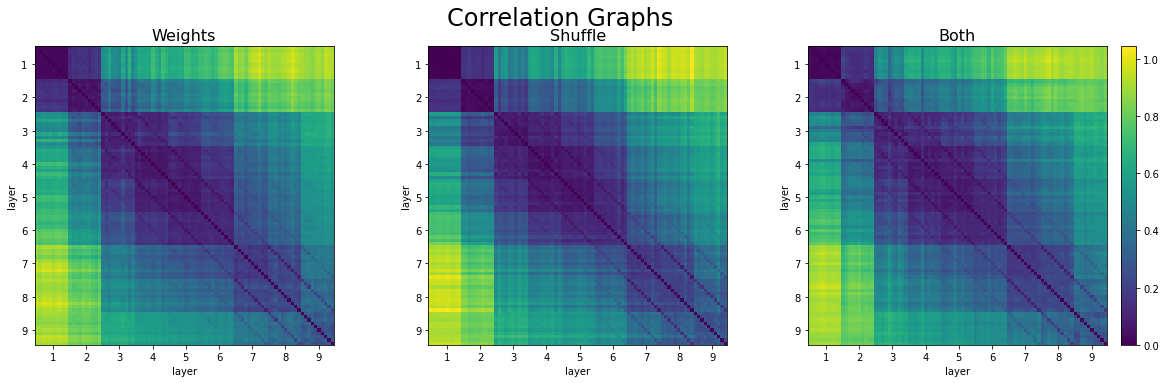

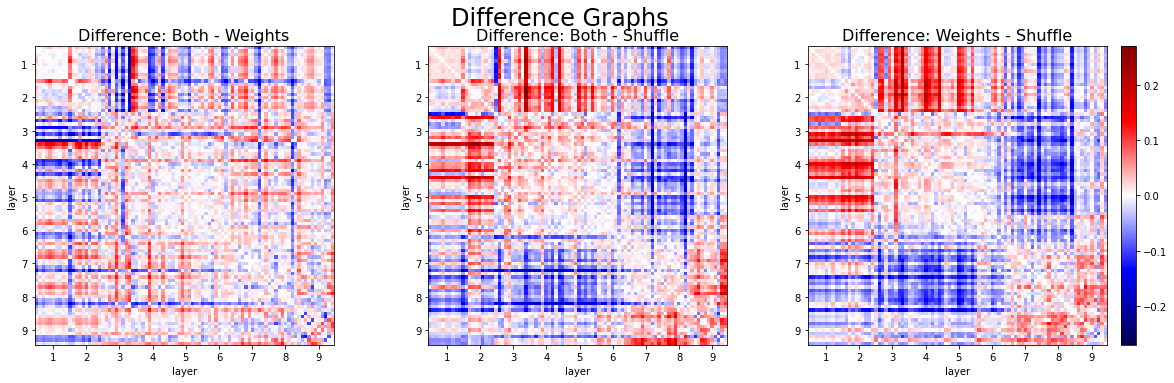

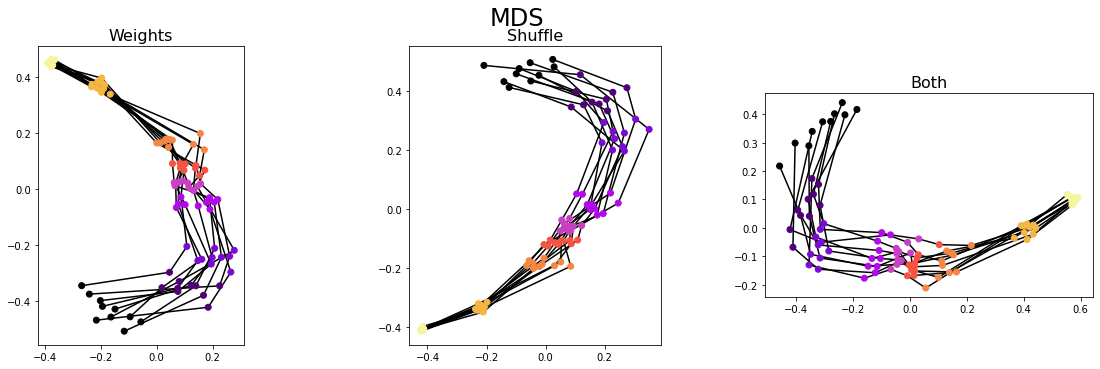

In [58]:
'''
Visualize RSA
'''
plot_triple_color(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both)
plot_triple_diff(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both)
plot_triple_mds(weights=rsa_weights, shuffle=rsa_shuffle, both=rsa_both)

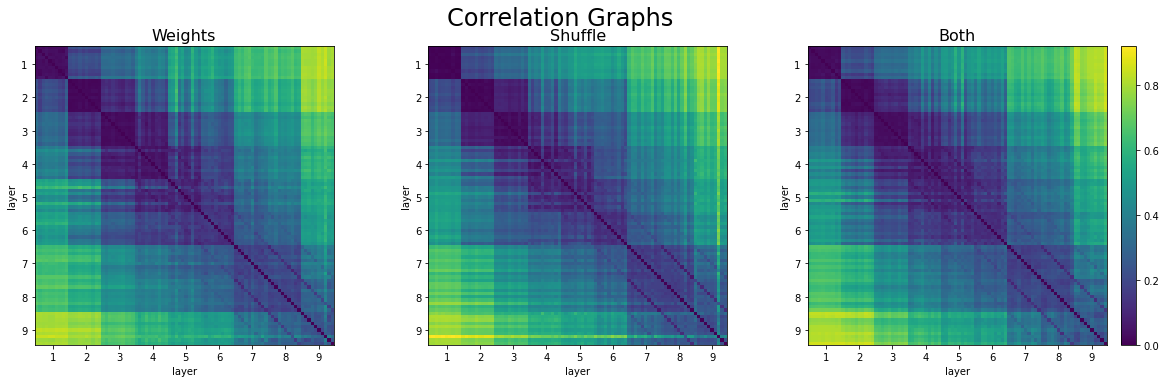

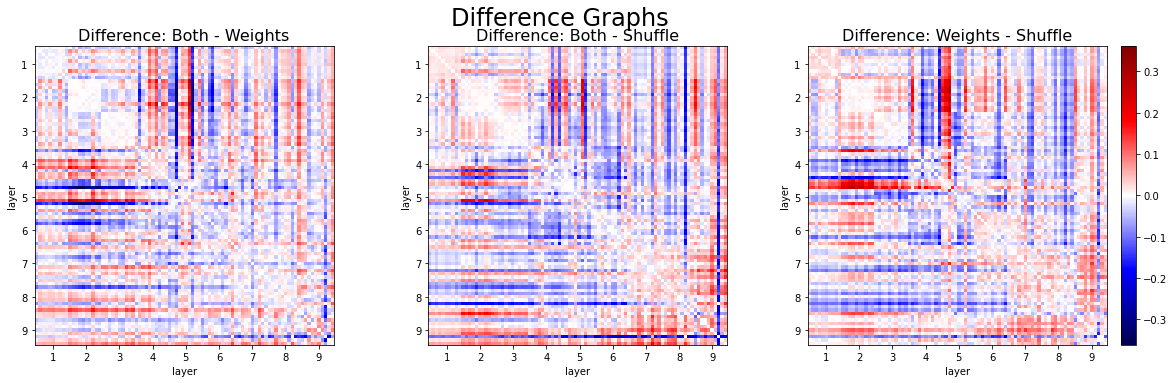

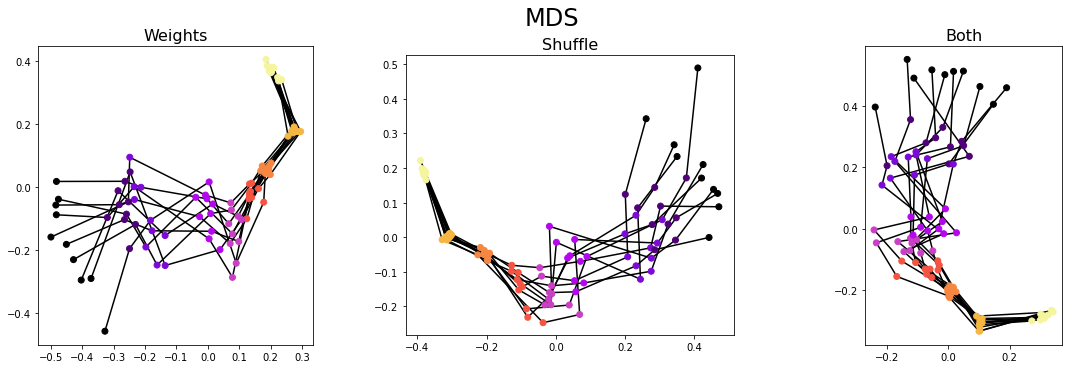

In [60]:
'''Visualize RSA with Cocktail Blank Normalization'''
plot_triple_color(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb)
plot_triple_diff(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb)
plot_triple_mds(weights=rsa_weights_cb, shuffle=rsa_shuffle_cb, both=rsa_both_cb)

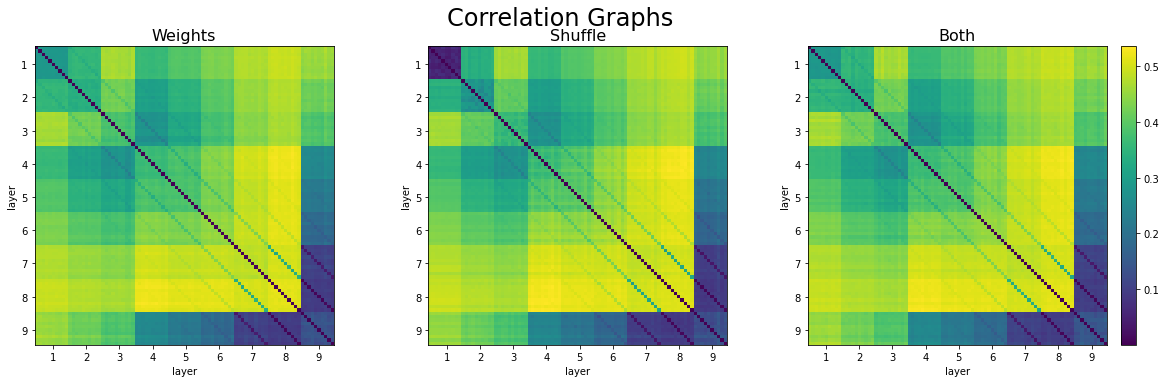

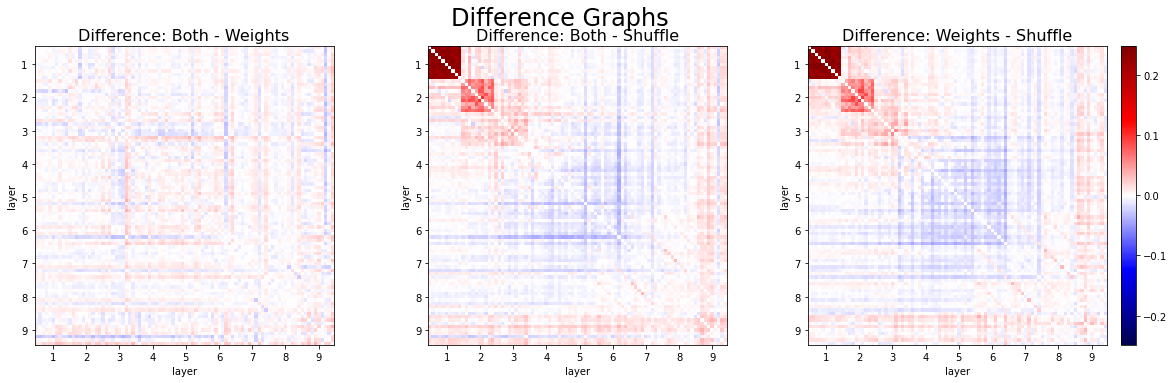

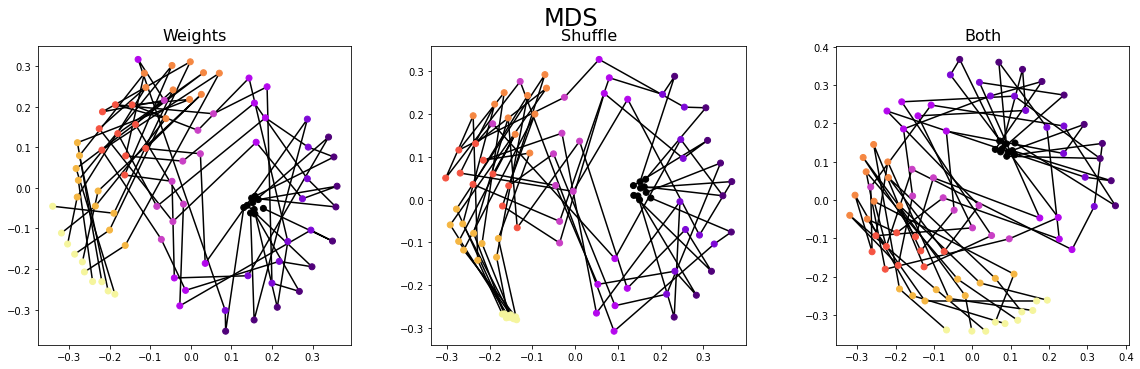

In [43]:
'''
Visualize SVCCA
'''
plot_triple_color(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both)
plot_triple_diff(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both)
plot_triple_mds(weights=svcca_weights, shuffle=svcca_shuffle, both=svcca_both)

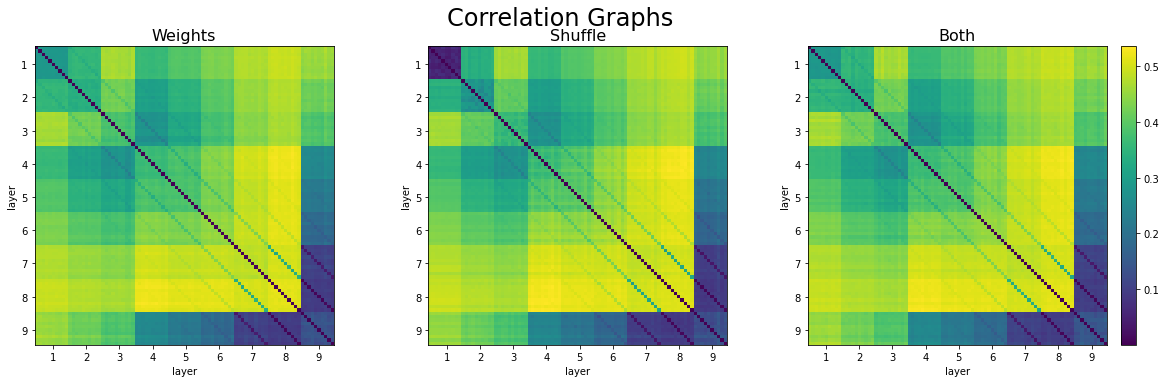

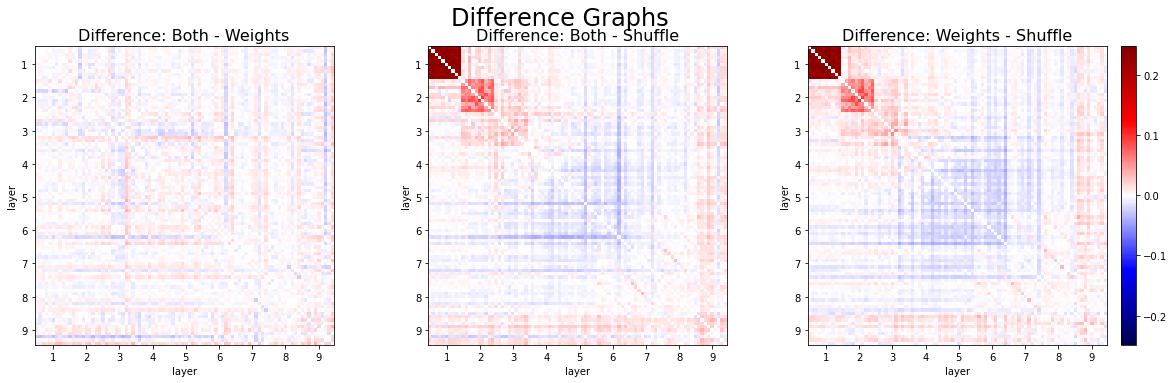

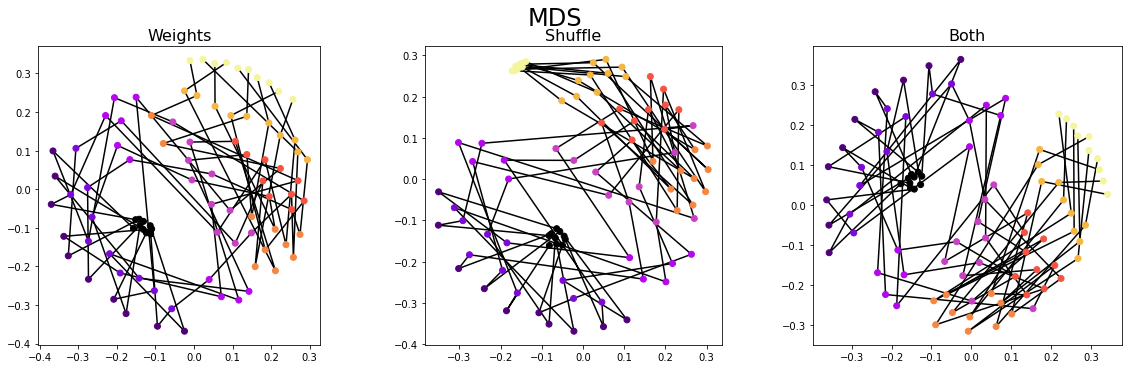

In [61]:
'''Visualize SVCCA with Cocktail Blank Normalization'''
plot_triple_color(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb)
plot_triple_diff(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb)
plot_triple_mds(weights=svcca_weights_cb, shuffle=svcca_shuffle_cb, both=svcca_both_cb)

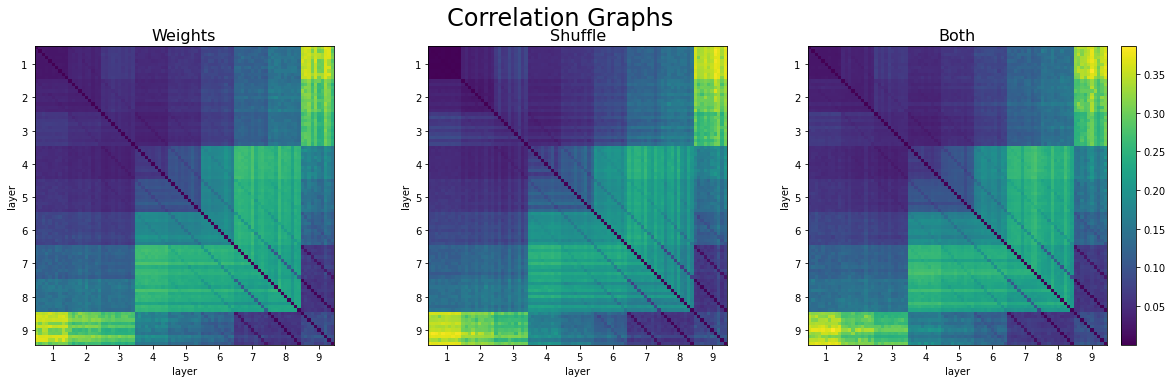

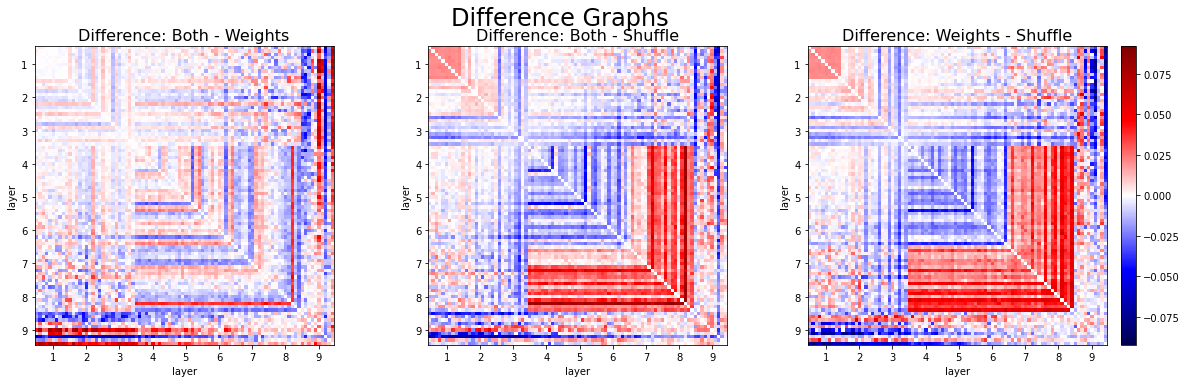

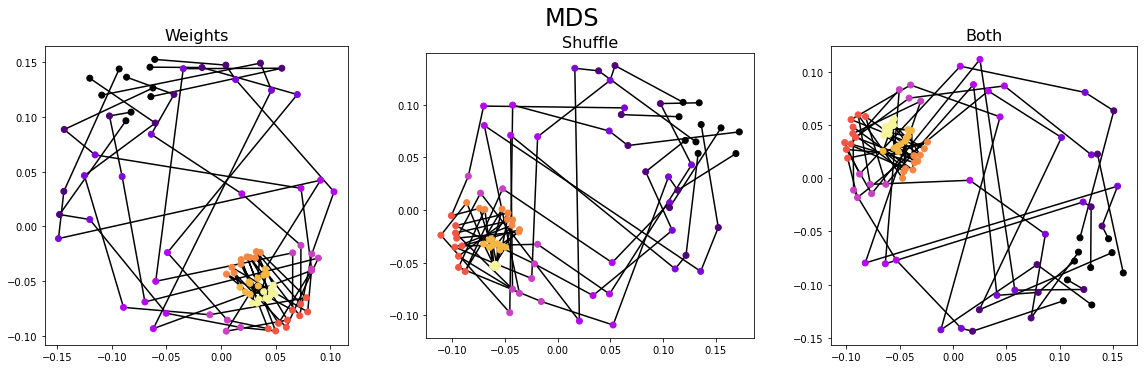

In [44]:
'''
Visualize PWCCA
'''
plot_triple_color(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both)
plot_triple_diff(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both)
plot_triple_mds(weights=pwcca_weights, shuffle=pwcca_shuffle, both=pwcca_both)

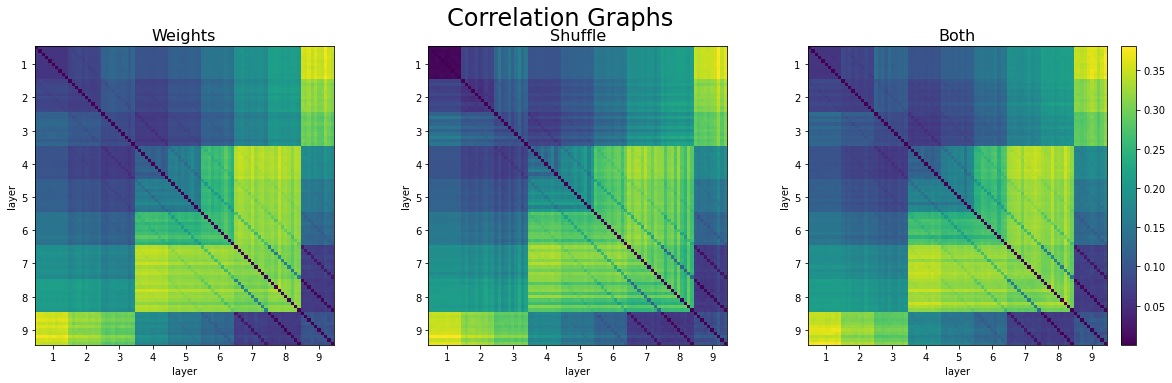

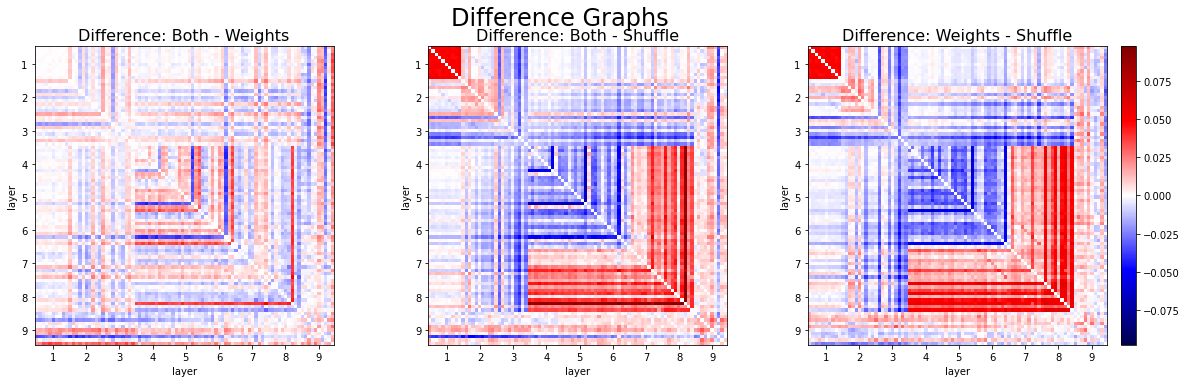

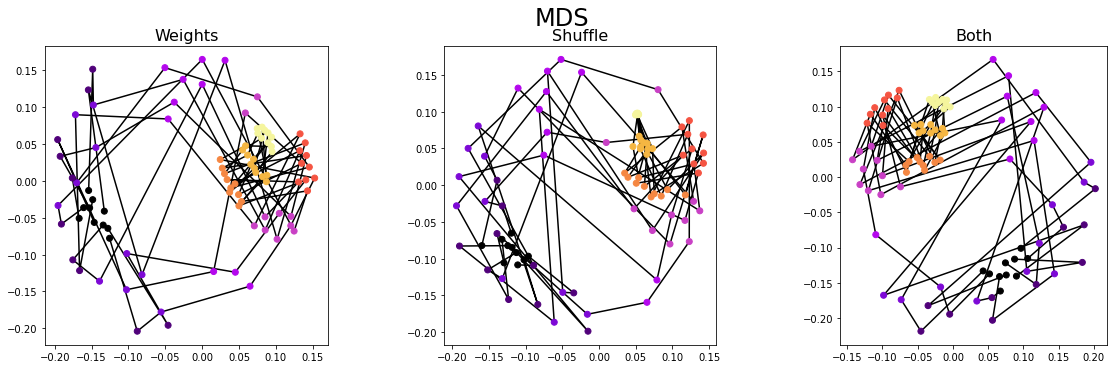

In [62]:
'''Visualize PWCCA with Cocktail Blank Normalization'''
plot_triple_color(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb)
plot_triple_diff(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb)
plot_triple_mds(weights=pwcca_weights_cb, shuffle=pwcca_shuffle_cb, both=pwcca_both_cb)

## Key findings thus far
- Overall, shuffle by itself appears to produce the most variance, demonstrated by a blurrier blocking structure in RSA and more striations in PWCCA
- Weights seem to overpower shuffle when varied together, so weights + shuffle ends up looking very similar to weights alone across all 3 correlation techniques
- This overpowering gets to the point where sometimes combining weights and shuffle creates *less* variance
- Outside of striations caused by the different alignment of outliers, these weight+shuffle anomalies seem to concentrate in the pooling layers (layers 3 and 6). See first RSA diff graph and 2nd+3rd PWCCA diff graphs
- Weights seems to create more variance in early layers (especially visible in SVCCA), while shuffle creates more variance in later laters, but weights again takes precedence in the last layer
- Utilizing multiple analysis techniques generates more insights than just one


In [9]:
'''
Visualize Transfrom Baseline
'''

color_rsa_weights = baseline.transform_baseline(x_predict, 'color', 
                                       load_model('../outputs/models/primary/instance_200.h5'),
                                       7, analysis.do_rsa)

### Transform: color with do_rsa
 - Working on version 0 of 201
 - Now correlating...
correlation: 0.23913300431509568
 - Working on version 1 of 201
 - Now correlating...
correlation: 0.23931251451616414
 - Working on version 2 of 201
 - Now correlating...
correlation: 0.23948889841570284
 - Working on version 3 of 201
 - Now correlating...
correlation: 0.23968544303099737
 - Working on version 4 of 201
 - Now correlating...
correlation: 0.2398418176616428
 - Working on version 5 of 201
 - Now correlating...
correlation: 0.23995322286726917
 - Working on version 6 of 201
 - Now correlating...
correlation: 0.24011745982869434
 - Working on version 7 of 201
 - Now correlating...
correlation: 0.24045542830324787
 - Working on version 8 of 201
 - Now correlating...
correlation: 0.24058463253167844
 - Working on version 9 of 201
 - Now correlating...
correlation: 0.2407654614785865
 - Working on version 10 of 201
 - Now correlating...
correlation: 0.2409011030694957
 - Working on version 1

 - Now correlating...
correlation: 0.24703539778688083
 - Working on version 95 of 201
 - Now correlating...
correlation: 0.24709470951363213
 - Working on version 96 of 201
 - Now correlating...
correlation: 0.2470518147754372
 - Working on version 97 of 201
 - Now correlating...
correlation: 0.24721693659091193
 - Working on version 98 of 201
 - Now correlating...
correlation: 0.24720062337038998
 - Working on version 99 of 201
 - Now correlating...
correlation: 0.24715751452481396
 - Working on version 100 of 201
 - Now correlating...
correlation: 0.24713889282443777
 - Working on version 101 of 201
 - Now correlating...
correlation: 0.24710292160253106
 - Working on version 102 of 201
 - Now correlating...
correlation: 0.247209491267949
 - Working on version 103 of 201
 - Now correlating...
correlation: 0.2472666305989212
 - Working on version 104 of 201
 - Now correlating...
correlation: 0.24724494181360435
 - Working on version 105 of 201
 - Now correlating...
correlation: 0.2471

 - Now correlating...
correlation: 0.24478387822497108
 - Working on version 189 of 201
 - Now correlating...
correlation: 0.24463627647248923
 - Working on version 190 of 201
 - Now correlating...
correlation: 0.2445811350211949
 - Working on version 191 of 201
 - Now correlating...
correlation: 0.2445941645409088
 - Working on version 192 of 201
 - Now correlating...
correlation: 0.2445873949392493
 - Working on version 193 of 201
 - Now correlating...
correlation: 0.24455901199439628
 - Working on version 194 of 201
 - Now correlating...
correlation: 0.24446633392917186
 - Working on version 195 of 201
 - Now correlating...
correlation: 0.24444323589629552
 - Working on version 196 of 201
 - Now correlating...
correlation: 0.24434248468126515
 - Working on version 197 of 201
 - Now correlating...
correlation: 0.24427841539837258
 - Working on version 198 of 201
 - Now correlating...
correlation: 0.24436756029540485
 - Working on version 199 of 201
 - Now correlating...
correlation: 

In [18]:
'''
Save weights
'''
# np.save('pwcca_weights.npy', pwcca_weights)
# np.save('pwcca_shuffle.npy', pwcca_shuffle)
# np.save('svcca_weights.npy', svcca_weights)
# np.save('svcca_shuffle.npy', svcca_shuffle)
# np.save('rsa_weights.npy', rsa_weights)
# np.save('rsa_shuffle.npy', rsa_shuffle)
# np.save('rsa_both.npy', rsa_both)
# np.save('pwcca_both.npy', pwcca_both)
# np.save('svcca_both.npy', svcca_both)
pwcca_weights = np.load('pwcca_weights.npy')
svcca_weights = np.load('svcca_weights.npy')
rsa_weights = np.load('rsa_weights.npy')
pwcca_shuffle = np.load('pwcca_shuffle.npy')
svcca_shuffle = np.load('svcca_shuffle.npy')
rsa_shuffle = np.load('rsa_shuffle.npy')
pwcca_both = np.load('pwcca_both.npy')
svcca_both = np.load('svcca_both.npy')
rsa_both = np.load('rsa_both.npy')


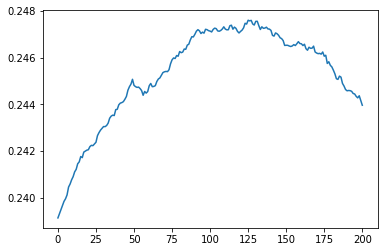

In [10]:
plt.plot(color_rsa_weights)